# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor

from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import xgboost as xgb
from xgboost import XGBRegressor

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import sys
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
train_data = pd.read_csv('../Datasets/train_V2.csv')

# Data Fields
DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Analysis, Cleansing, Engineering, Pre-Processing

### View the dataset

In [60]:
train_data

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


### Check column names, data types

In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Check missing values

In [62]:
is_NaN = train_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train_data[row_has_NaN]
rows_with_NaN

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


#### Data Cleansing 1
Delete Missing Value, Ids

In [3]:
def delete_useless_data(train_data):
    
    #Maintain the original data
    train_data_ = train_data.copy()
    
    #Delete Ids
    train_data_ = train_data_.drop(["Id","groupId","matchId"],axis=1)
    
    #Drop the missing value
    train_data_ = train_data_.drop(2744604)
    
    #Reset the index
    train_data_ = train_data_.reset_index(drop=True)
    
    #Get y
    y_train = train_data_["winPlacePerc"]
    
    #Get X
    X_train = train_data_.drop(["winPlacePerc"],axis=1)
    
    return X_train,y_train,train_data_

In [4]:
X_train,y_train,train = delete_useless_data(train_data)

### Feature Plotting 

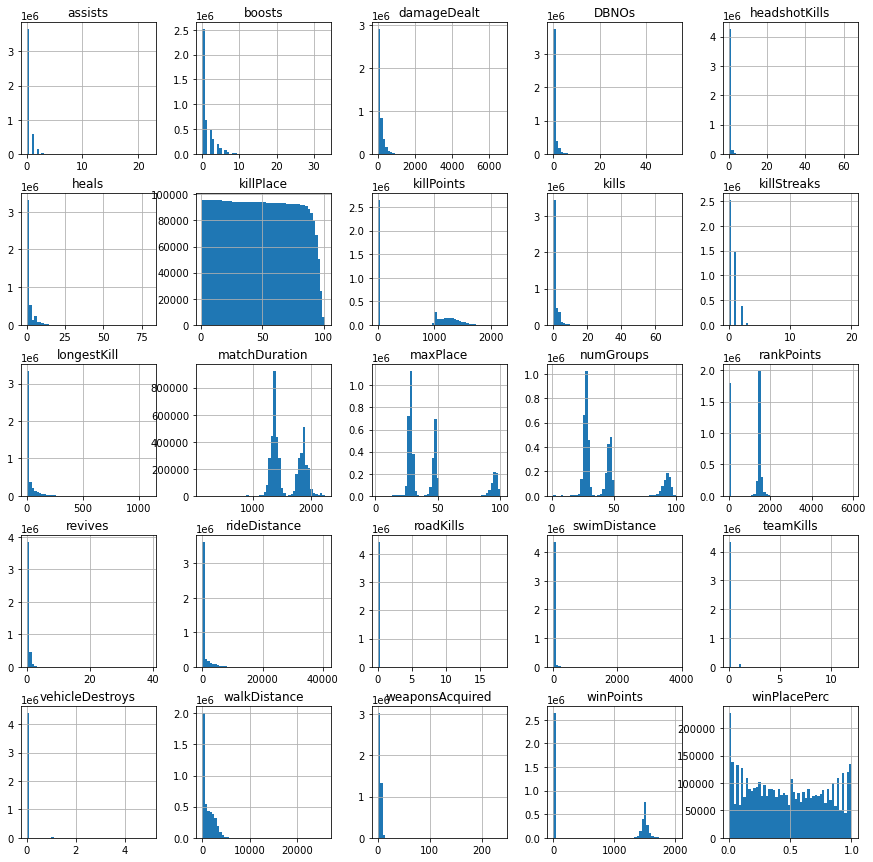

In [9]:
train.hist(bins=50, layout=(5,5),figsize=(15, 15))
plt.show()

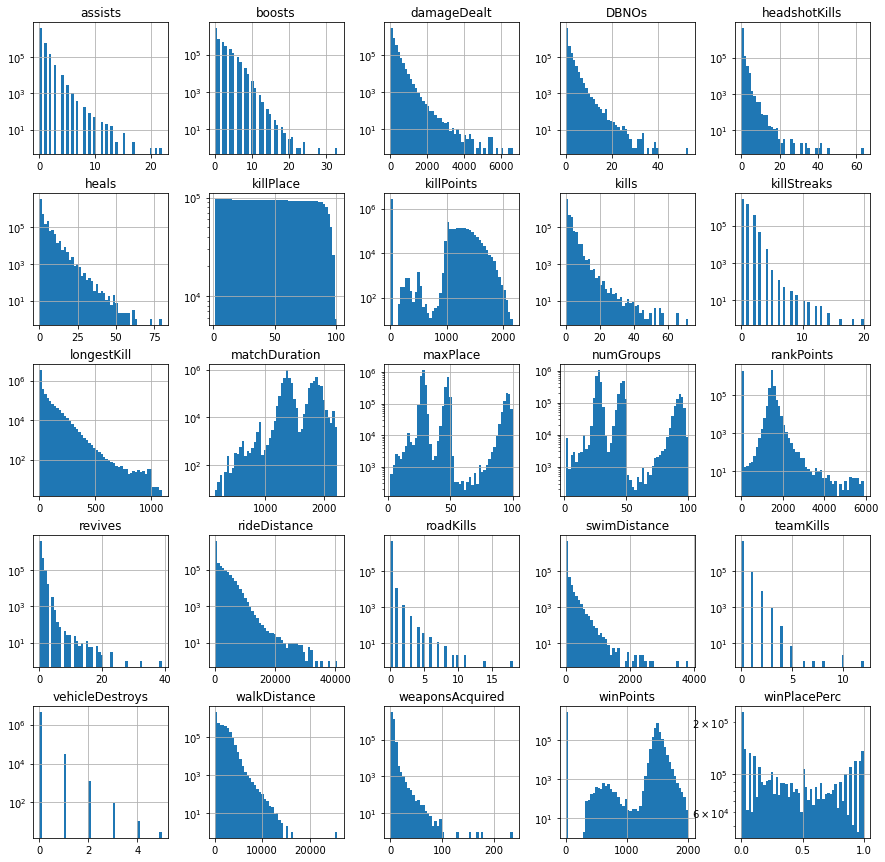

In [8]:
#Log scale
train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
plt.show()

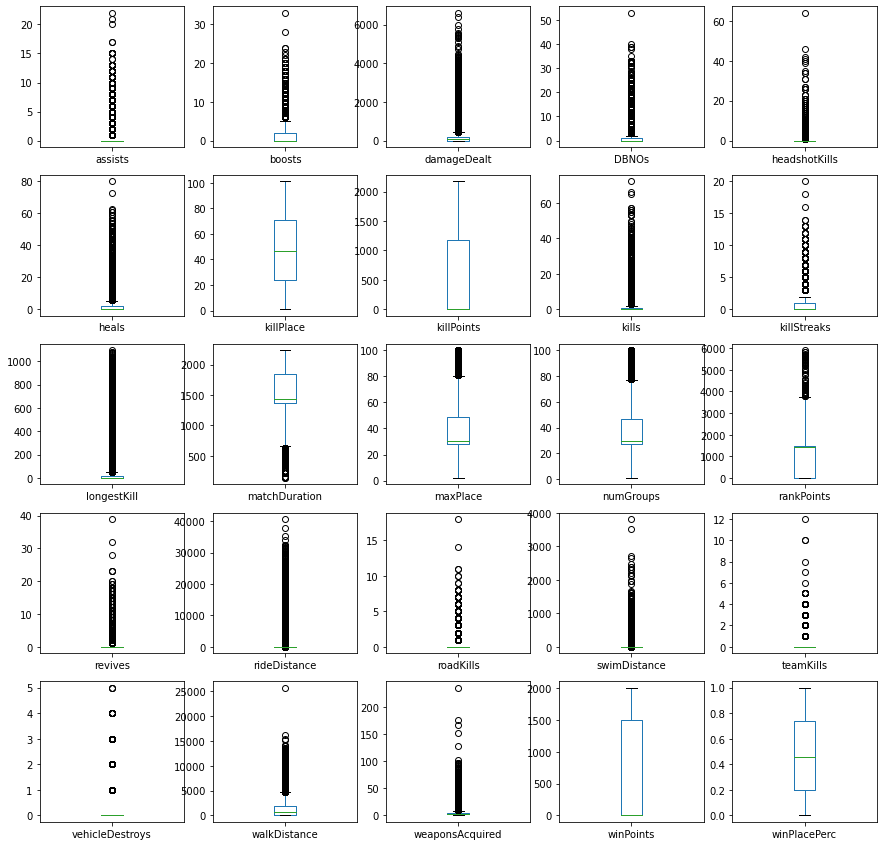

In [66]:
train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

### Data Normalization 
Min-Max Normalization

In [5]:
def normalize_data(dataset):
    
    #Maintain the original data
    dataset_ = dataset.copy()
    
    #Get data other than categorical data
    dataset_quantitative = dataset_.loc[:, dataset_.columns != 'matchType']
    
    #Do Min-Max normalization in each row
    for feature in dataset_quantitative:
        dataset_[feature]=(dataset_[feature]-dataset_[feature].min())/(dataset_[feature].max()-dataset_[feature].min())
        
    return dataset_

In [6]:
#Normalize the cleaned X
X_train = normalize_data(X_train)

#Get the new total training set with normalized X
train = pd.concat([X_train,y_train],axis=1)

### Cluster Analysis

In [7]:
def getAverageWPP(y,n_clusters):
    
    #Initialize a list for storing the means with n_clusters 0s
    means = [0]*n_clusters
    
    #Get the mean in each cluster
    for i in range(n_clusters):
        means[i] = y[y["cluster"] == i]["winPlacePerc"].mean()
        
    return means

In [8]:
#One hot encoding for matchType in order to do clustering
#X_train_temp = pd.get_dummies(data = X_train, columns = ["matchType"])

#Delete matchType
X_train_temp = X_train.drop(["matchType"],axis=1)

#Turn numpy array into pandas dataframe
y_train_temp = pd.DataFrame({"winPlacePerc": y_train})

### Kmeans: random_state and n_init

By answering your last week's comment "*I don't understand what this(random_state=200) means. I assume KMeans.n_init is the number of initialisations… what is done 200 times?*":

Yes, **KMeans.n_init** is the number of initialisations. 

**KMeans.random_state** is a seed that determines random number generation for the initialisations. 

***If set to None***

Use the global random state instance from numpy.random. Calling the function multiple times will reuse the same instance, and will produce different results.

***If set to An Integer***

Use a new random number generator seeded by the given integer. Using an int will produce the same results across different calls. However, it may be worthwhile checking that your results are stable across a number of different distinct random seeds. Popular integer random seeds are 0 and 42.

*I'm using integer random_states because "using an int will produce the same results across different calls". Thus it will be easy if I'd like to reproduce the results.*

In [9]:
#Initialize kmeans with different n_init and different seed
kmeans_1 = KMeans(random_state=10,n_init = 10)
kmeans_2 = KMeans(random_state=20,n_init = 10)
kmeans_3 = KMeans(random_state=30,n_init = 50)
kmeans_4 = KMeans(random_state=40,n_init = 50)

### Metrics for clustering
By checking the documents again, https://scikit-learn.org/stable/modules/clustering.html, 3 metrics are suggested for this case by scikit-learn:

**Silhouette Coefficient:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

**Calinski-Harabasz Index:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score

**Davies-Bouldin Index:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score

#### First run with n_init = 10

In [12]:
#Used to do score VS n_clustet plotting
scores_1 = []
Xs_1 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_1.n_clusters = i
    
    #Train the model
    kmeans_1.fit(X_train_temp)

    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_1.labels_)

    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_1.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_1.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_1.append(i)
    
    #Append the score
    scores_1.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  4607744.423608125 ,Average WPP:  [0.47246916165694697, 0.4733459417043119]
n_clusters:  3 ,Score:  4099177.786435839 ,Average WPP:  [0.470278832378692, 0.46887622015053565, 0.4908197658677006]
n_clusters:  4 ,Score:  3908698.569066404 ,Average WPP:  [0.4700819070665798, 0.49030084534140683, 0.49235934336013676, 0.4688854537351886]
n_clusters:  5 ,Score:  4185958.2400060487 ,Average WPP:  [0.4701179885663027, 0.30565365066137073, 0.4923614648368927, 0.6324483362924019, 0.4902938191562543]
n_clusters:  6 ,Score:  4512235.336299567 ,Average WPP:  [0.3112278288013428, 0.30664236642526826, 0.49029430274173386, 0.49207009796804174, 0.6299181224897616, 0.6322290613289939]
n_clusters:  7 ,Score:  4148488.0022721435 ,Average WPP:  [0.31234997731953407, 0.6322846937740642, 0.3063683686437053, 0.49220766731768106, 0.31475136853597746, 0.6296964942212004, 0.6673209904851317]
n_clusters:  8 ,Score:  3945070.7514451356 ,Average WPP:  [0.31118927769620125, 0.5409844103557099, 

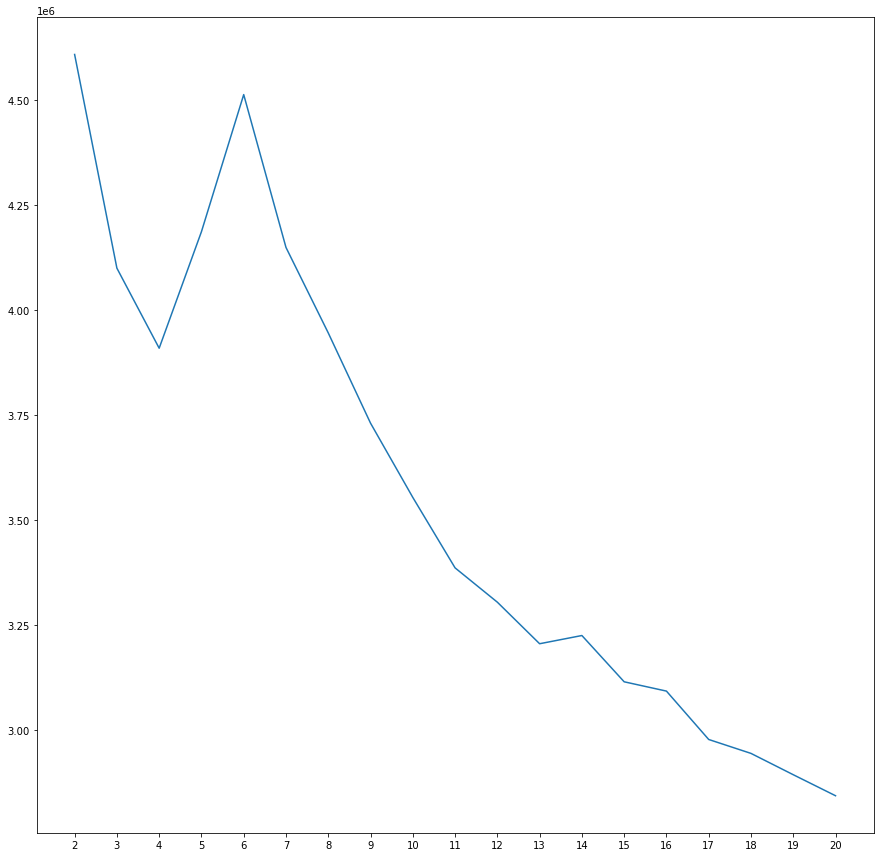

In [13]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_1,scores_1)
plt.xticks(Xs_1)
plt.savefig("Kmeans_1.png")
plt.show()

#### Second run with n_init = 10

In [14]:
#Used to do score VS n_clustet plotting
scores_2 = []
Xs_2 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_2.n_clusters = i
    
    #Train the model
    kmeans_2.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_2.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_2.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_2.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_2.append(i)
    
    #Append the score
    scores_2.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  4607744.423608125 ,Average WPP:  [0.47246916165694697, 0.4733459417043119]
n_clusters:  3 ,Score:  4099177.789076801 ,Average WPP:  [0.46887622015053565, 0.4702776656540677, 0.490821958469659]
n_clusters:  4 ,Score:  3908698.5697160256 ,Average WPP:  [0.4700819070665798, 0.4688853266852148, 0.4903015259334515, 0.49235934336013676]
n_clusters:  5 ,Score:  4185958.246079993 ,Average WPP:  [0.30566266078511645, 0.49235934336013676, 0.6324456560984939, 0.4902930381923759, 0.4701184259736445]
n_clusters:  6 ,Score:  4512237.201678688 ,Average WPP:  [0.3119692763546739, 0.3059802233097841, 0.6323883980254501, 0.6297714152115185, 0.49029430274173386, 0.4920698191571878]
n_clusters:  7 ,Score:  4148501.6110426886 ,Average WPP:  [0.6325560726500513, 0.31079162910908703, 0.3133696565219538, 0.6300013263627063, 0.3051526262116237, 0.667629882641995, 0.49220940438152605]
n_clusters:  8 ,Score:  3945098.086780589 ,Average WPP:  [0.5413513123970353, 0.6298506875933247, 0.3115

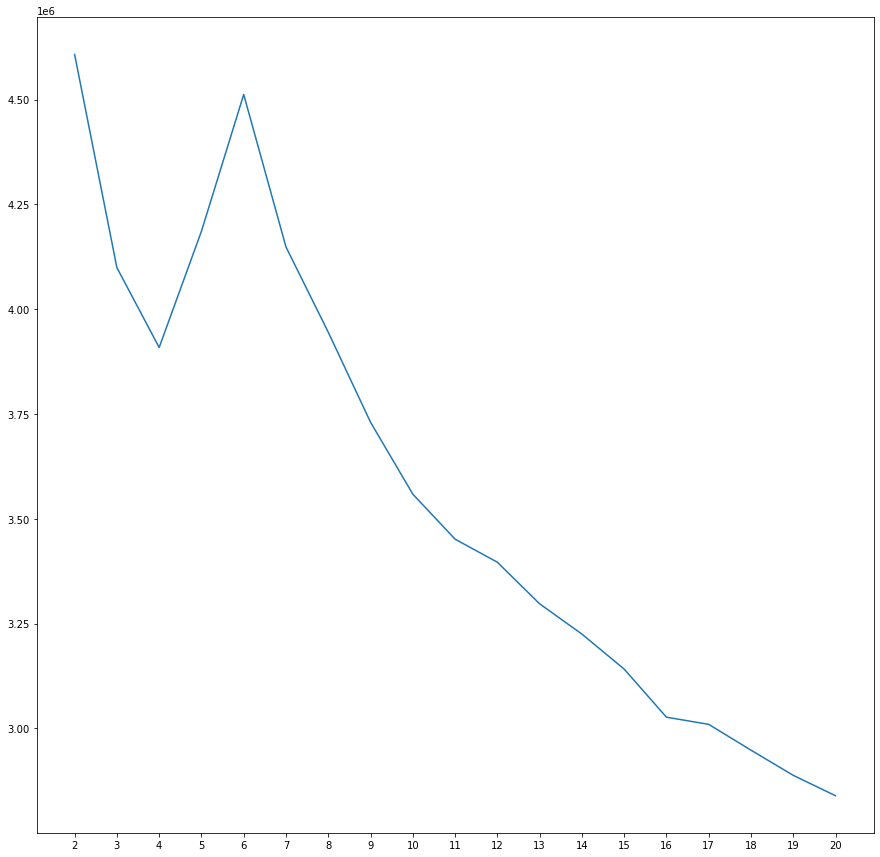

In [15]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_2,scores_2)
plt.xticks(Xs_2)
plt.savefig("Kmeans_2.png")
plt.show()

#### First run with n_init = 50

In [16]:
#Used to do score VS n_clustet plotting
scores_3 = []
Xs_3 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_3.n_clusters = i
    
    #Train the model
    kmeans_3.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_3.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_3.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_3.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_3.append(i)
    
    #Append the score
    scores_3.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  4607744.423608125 ,Average WPP:  [0.4733459417043119, 0.47246916165694697]
n_clusters:  3 ,Score:  4099177.7850067704 ,Average WPP:  [0.4702787832444161, 0.46887622015053565, 0.49081990227135736]
n_clusters:  4 ,Score:  3908698.5697160256 ,Average WPP:  [0.4688853266852148, 0.49235934336013676, 0.4700819070665798, 0.4903015259334515]
n_clusters:  5 ,Score:  4185958.2457754007 ,Average WPP:  [0.6324482125326116, 0.49235934336013676, 0.4701184259736445, 0.4902930381923759, 0.3056545104030723]
n_clusters:  6 ,Score:  4512236.186610641 ,Average WPP:  [0.6297714152115185, 0.6325206736023671, 0.3119692763546739, 0.4902930381923759, 0.3053609847633336, 0.4920698191571878]
n_clusters:  7 ,Score:  4148501.0813001813 ,Average WPP:  [0.6300369476098151, 0.6673509769326571, 0.6322987435773235, 0.49220940438152605, 0.3146206308213569, 0.30631417075016193, 0.310621538205745]
n_clusters:  8 ,Score:  3945093.331020414 ,Average WPP:  [0.17622688201857753, 0.49220940438152605, 0.

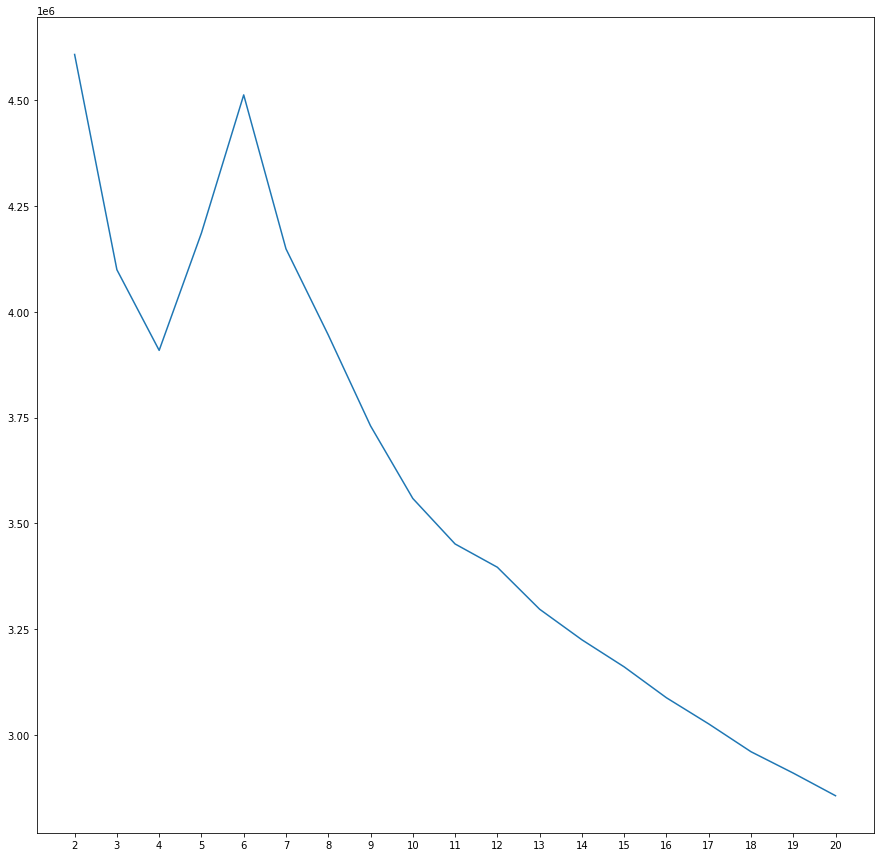

In [17]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_3,scores_3)
plt.xticks(Xs_3)
plt.savefig("Kmeans_3.png")
plt.show()

#### Second run with n_init = 50

In [18]:
#Used to do score VS n_clustet plotting
scores_4 = []
Xs_4 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_4.n_clusters = i
    
    #Train the model
    kmeans_4.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_4.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_4.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_4.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_4.append(i)
    
    #Append the score
    scores_4.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  4607744.423608125 ,Average WPP:  [0.4733459417043119, 0.47246916165694697]
n_clusters:  3 ,Score:  4099177.789076801 ,Average WPP:  [0.490821958469659, 0.46887622015053565, 0.4702776656540677]
n_clusters:  4 ,Score:  3908698.5697160256 ,Average WPP:  [0.4700819070665798, 0.4688853266852148, 0.4903015259334515, 0.49235934336013676]
n_clusters:  5 ,Score:  4185958.244610981 ,Average WPP:  [0.4902930381923759, 0.632444277038181, 0.49235934336013676, 0.3056714044785233, 0.4701184259736445]
n_clusters:  6 ,Score:  4512236.927634691 ,Average WPP:  [0.3120296117188783, 0.30573531765431716, 0.6297603069233628, 0.4920698191571878, 0.4902930381923759, 0.6324415499750927]
n_clusters:  7 ,Score:  4148505.902082795 ,Average WPP:  [0.3112036076396152, 0.3059107934386969, 0.6299232262627485, 0.6323934151457618, 0.31333090098703253, 0.6676383099732276, 0.49220746360498857]
n_clusters:  8 ,Score:  3945085.758577212 ,Average WPP:  [0.6299283765489538, 0.6992458149976981, 0.667484

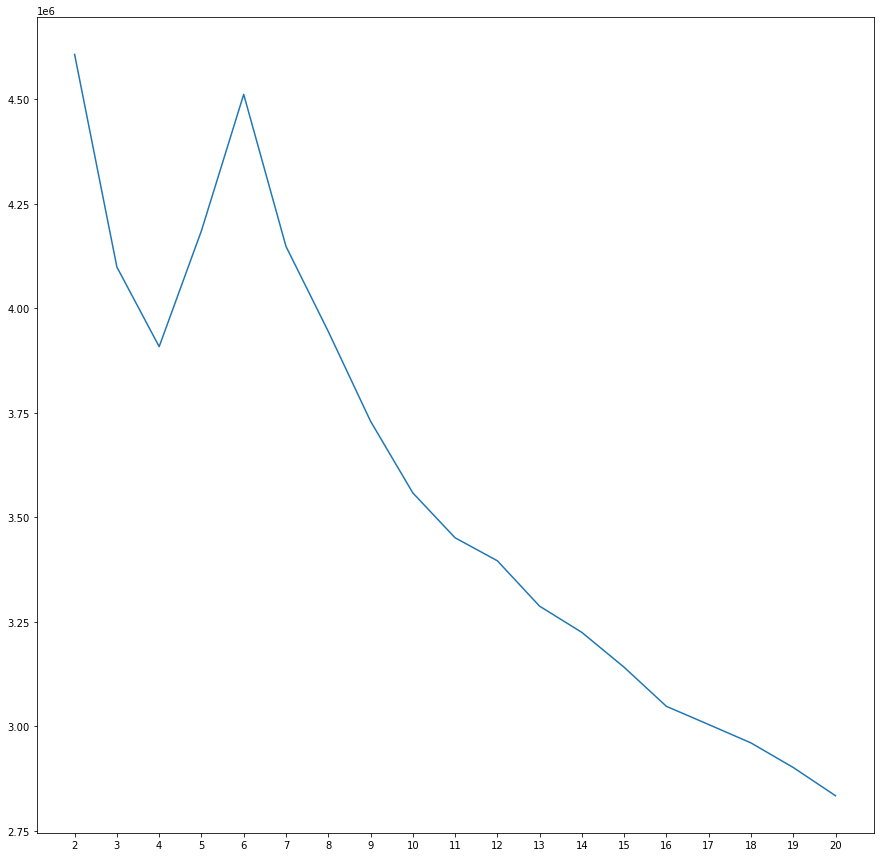

In [19]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_4,scores_4)
plt.xticks(Xs_4)
plt.savefig("Kmeans_4.png")
plt.show()

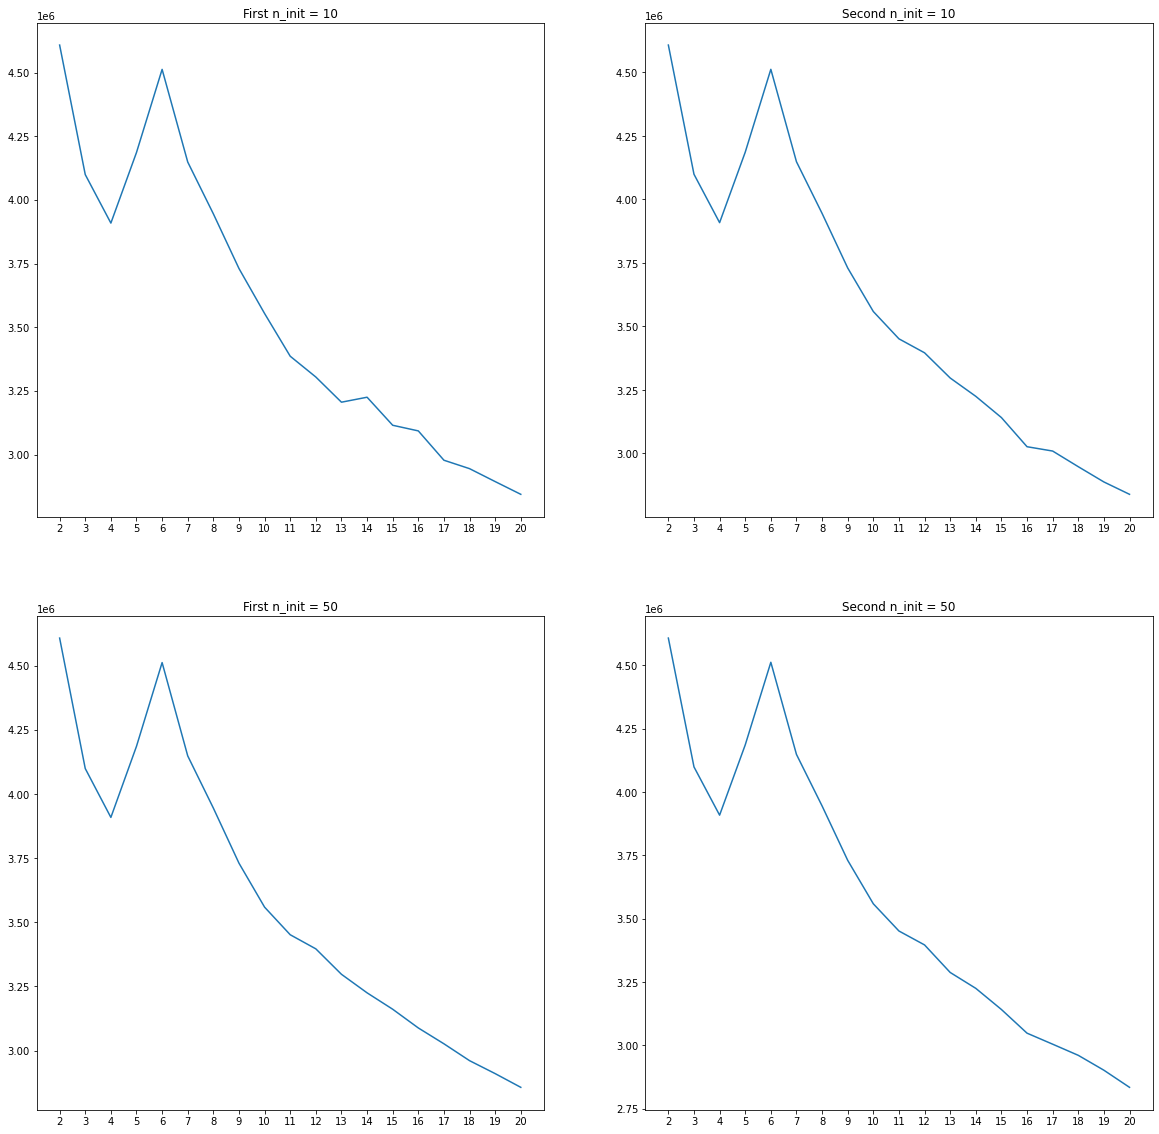

In [20]:
plt.figure(figsize = (20,20))
ax = plt.subplot(2,2,1)
ax.plot(Xs_1,scores_1)
ax.set_title("First n_init = 10")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,2)
ax.plot(Xs_2,scores_2)
ax.set_title("Second n_init = 10")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,3)
ax.plot(Xs_3,scores_3)
ax.set_title("First n_init = 50")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,4)
ax.plot(Xs_4,scores_4)
ax.set_title("Second n_init = 50")
plt.xticks(Xs_1)
plt.savefig("combined.png")
plt.show()

### Choose the number of clusters
The four plots are similar, with highest score when n_cluster = 2 and another peak when n_cluster = 6. I'd like to distinguish between 2 clusters and no clusters when n_cluster = 2. If there are no clusters then n_cluster = 6 may be preferred. And personally I think n_clusters = 6 should be better because it shows different WPP. 

In [109]:
def distinguish_clusters(kmeans,X_train_temp,y_train_temp,n_clusters,title):
    
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
    
    #Set the n_clusters
    kmeans.n_clusters = n_clusters
    
    #Get the clusters
    kmeans.fit(X_train_temp)
    
    #Get average wpp
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Get the centroids
    centroids = kmeans.cluster_centers_
    
    #Get the centroid for the whole dataset
    kmeans.n_clusters = 1
    kmeans.fit(X_train_temp)
    np.append(centroids,kmeans.cluster_centers_)

    #Append centroids to the pandas dataframe for showing a table
    for centroid in centroids:
        X_train_temp.loc[len(X_train_temp)]=centroid
    
    #Extract the centroids
    average_data = X_train_temp.tail(n_clusters+1)
    
    xticks = []
    for i in range(24):
        xticks.append(i)
    
    #Plot the features
    average_data.T.plot.line(figsize = (30,15),title = title,xticks=xticks)
    locs, labels=plt.xticks()
    
    plt.xticks(locs,['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'])
    legends = []
    for i in range(n_clusters):
        legends.append("Cluster "+str(i+1)+"- average_Wpp "+str(average_Wpp[i]))
    legends.append("Whole dataset")
    plt.legend(legends)
    plt.show()

##### It seems that 2 clusters do exist

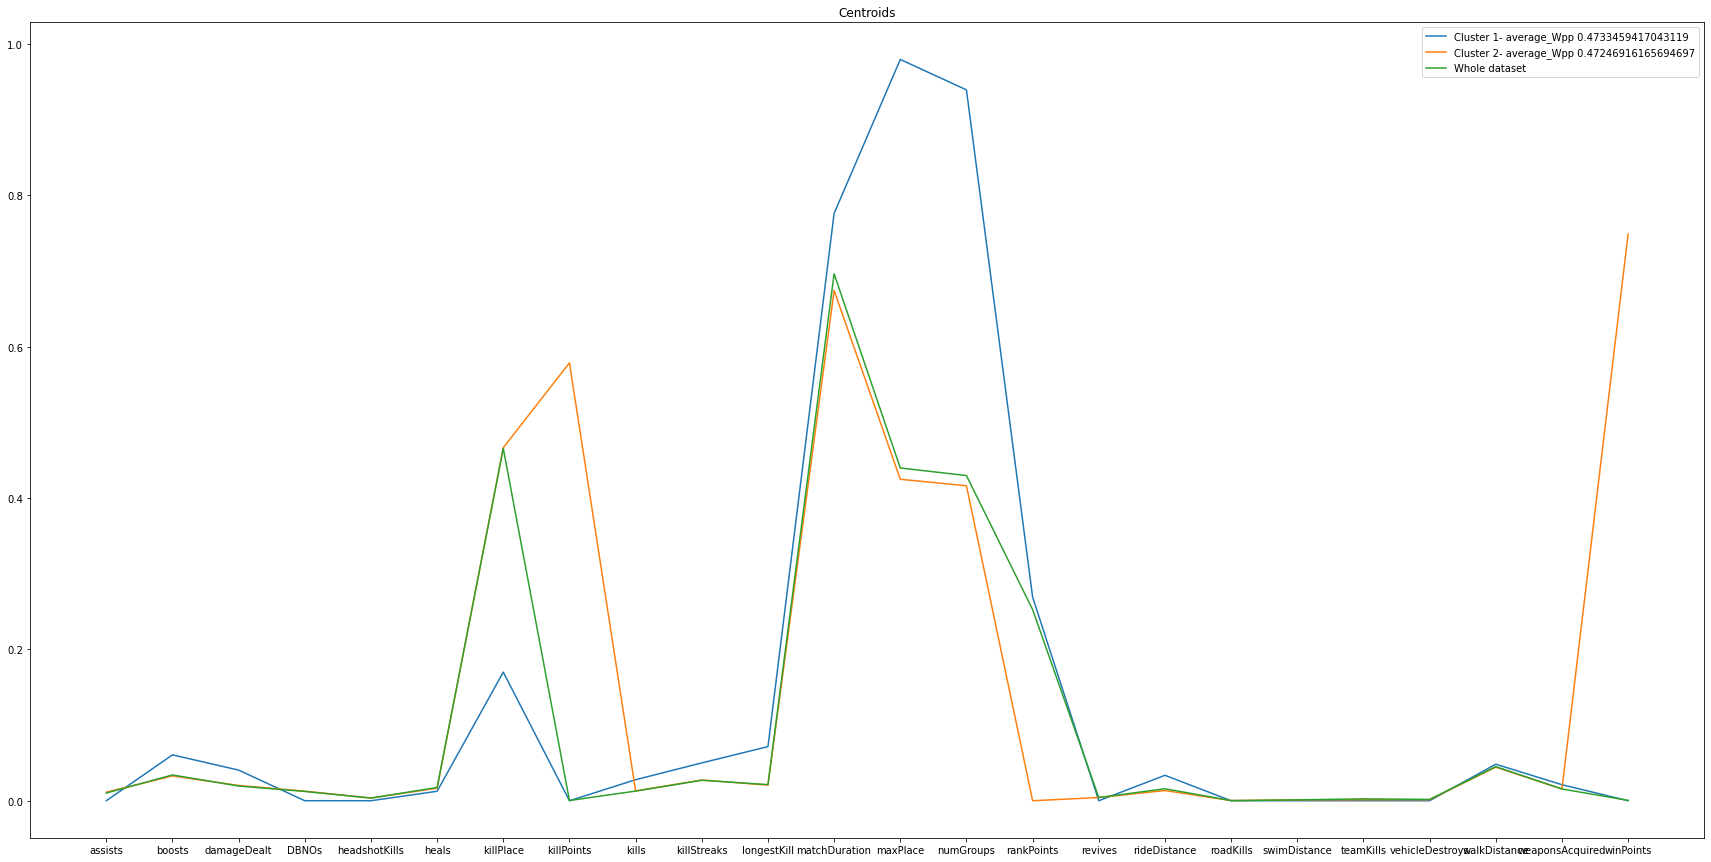

In [96]:
distinguish_clusters(kmeans_4,X_train_temp,y_train_temp,2,"Centroids")

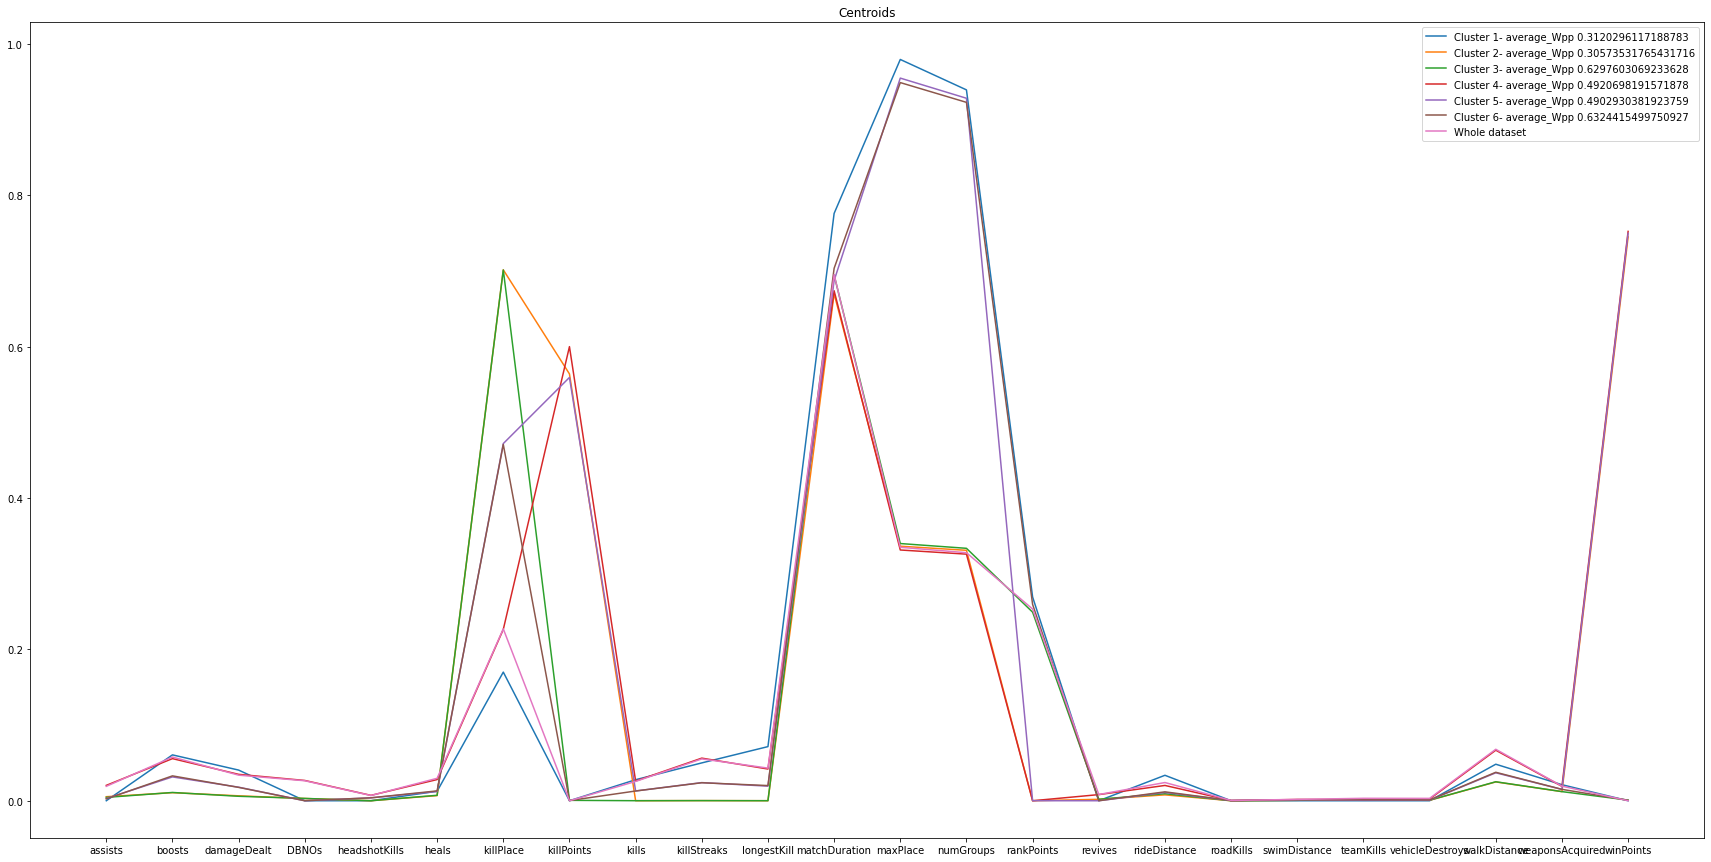

In [97]:
#Curious about the results for the six clusters
distinguish_clusters(kmeans_4,X_train_temp,y_train_temp,6,"Centroids")

### Distribution plotting
Too messy, currently not in use

In [28]:
def plot_distributions(X_train_temp,y_train_temp,kmeans,n_clusters):
    
    #Maintain the original data
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
        
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    
    #Add cluster columns
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Show plots for each cluster
    for n in range(n_clusters):
        
        #Get the Xs with cluster == n
        X_temp_train = X_train_temp[X_train_temp["cluster"] == n]
        
        #Delete the cluster column
        X_temp_train = X_temp_train.drop(["cluster"],axis=1) 
        
        #Get the ys with cluster == n
        y_temp_train = y_train_temp[y_train_temp["cluster"]==n]
        
        #Delete the cluster column
        y_temp_train = y_temp_train.drop(["cluster"],axis=1) 
        
        #New whole training set
        temp_train = pd.concat([X_temp_train,y_temp_train],axis=1)
        
        #Delete the match type columns
        cols = [c for c in temp_train.columns if c.lower()[:9] != 'matchtype']
        temp_train = temp_train[cols]
        
        print("Cluster "+str(n+1)+", average wpp = "+str(average_Wpp[n]))
        
        #Plot the histogram
        ax_hist = temp_train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
        for x in range(ax_hist.shape[0]):
            for y in range(ax_hist.shape[1]):
                ax_hist[x][y].set_xlim((0,1))
        plt.show()
        
        #Plot the box plots
        temp_train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
        plt.show()

##### Find the nearest points to the centroid
Don't think it's useful, currently not in use.

In [11]:
def get_closest(X,kmeans,y_train_temp,n_clusters):
    
    #Maintain the original data
    y_train_temp = y_train_temp.copy()
    
    #Get the closest position
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    
    #Add a cluster column for calculating the average WPP
    y_train_temp["cluster"] = kmeans.labels_
    
    #Calculate the average WPP
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Delete the cluster column
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 
    
    #Get the new whole training set
    temp_train = pd.concat([X,y_train_temp],axis=1)
    
    #Find the indices of closest points
    closest_data = temp_train.loc[closest]
    
    #Add an averageWpp column
    closest_data["averageWpp"] = average_Wpp
        
    return closest_data

##### Find the centroids together with most common matchtype, dominance of that type (eg 0.75 vs. 0.25) and average wPP

In [93]:
def get_centroids(X_out,X_with,kmeans,n_clusters,y_train_temp):
    
    #Maintain the original data
    X = X_out.copy()
    X_with = X_with.copy()
    
    #Train kmeans
    kmeans.n_clusters = n_clusters
    kmeans.fit(X)
    
    #Get the centroids
    centroids = kmeans.cluster_centers_
    
    #Get the most common matchtype and dominance
    most_common_matchTypes = []
    dominance = []
    X_with["cluster"] = kmeans.labels_
    
    for i in range(n_clusters):
        temp_cluster = X_with[X_with["cluster"] == i]
        most_common_type = temp_cluster['matchType'].mode()[0]
        most_common_type_count = temp_cluster['matchType'].value_counts()[most_common_type]
        most_common_matchTypes.append(most_common_type)
        filtered_temp_cluster = temp_cluster[temp_cluster['matchType'] != most_common_type]
        filtered_common_type = filtered_temp_cluster['matchType'].mode()[0]
        filtered_type_count = filtered_temp_cluster['matchType'].value_counts()[filtered_common_type]
        dominance.append((most_common_type_count-filtered_type_count)/most_common_type_count)
        
    
    #Append centroids to the pandas dataframe for showing a table
    for centroid in centroids:
        X.loc[len(X)]=centroid
    
    #Extract the centroids
    average_data = X.tail(n_clusters)
    
    #Get the average WPP
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Add columns for most common matchtype, dominance and average WPP
    average_data["most_common"] = most_common_matchTypes
    average_data["dominance"] = dominance
    average_data["averageWpp"] = average_Wpp
    
    index = []
    for i in range(n_clusters):
        index.append("cluster_"+str(i+1))
    average_data.index = index
    
    return average_data

In [98]:
def compare_clusters(kmeans,X_train_temp,y_train_temp,n_clusters):
    
    #Similar code with distinguish_clusters
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
    
    #Set the n_clusters
    kmeans.n_clusters = n_clusters
    
    #Get the clusters
    kmeans.fit(X_train_temp)
    
    #Get average wpp
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Get the centroids
    centroids = kmeans.cluster_centers_
    
    #Append centroids to the pandas dataframe for showing a table
    for centroid in centroids:
        X_train_temp.loc[len(X_train_temp)]=centroid
    
    #Extract the centroids
    average_data = X_train_temp.tail(n_clusters)
    
    xticks = []
    for i in range(24):
        xticks.append(i)
    
    #Plot the features
    average_data.T.plot.line(figsize = (30,15),title = "Centroids",xticks=xticks)
    locs, labels=plt.xticks()
    
    plt.xticks(locs,['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'])
    legends = []
    for i in range(n_clusters):
        legends.append("Cluster "+str(i+1)+"- average_Wpp "+str(average_Wpp[i]))
    plt.legend(legends)
    plt.show()

##### n_clusters = 2 seems to get similar clusters except rankPoints and killPoints

In [94]:
centroids = get_centroids(X_train_temp,X_train,kmeans_4,2,y_train_temp)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(centroids)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,most_common,dominance,averageWpp
cluster_1,0.010160,0.034066,0.01946,0.012266,0.003522,0.017506,0.465588,0.000260,0.012780,0.027025,0.021306,0.696423,0.439708,0.429737,0.252595,0.004209,0.015833,0.000212,0.001202,0.002457,0.001766,0.045031,0.015565,0.000464,squad-fpp,0.399725,0.472469
cluster_2,0.011325,0.032764,0.02020,0.012631,0.003577,0.016563,0.466597,0.578641,0.012939,0.027455,0.020599,0.674229,0.424812,0.416257,0.000008,0.004241,0.013483,0.000168,0.001147,0.001293,0.001313,0.044386,0.015429,0.748895,squad-fpp,0.476635,0.473346


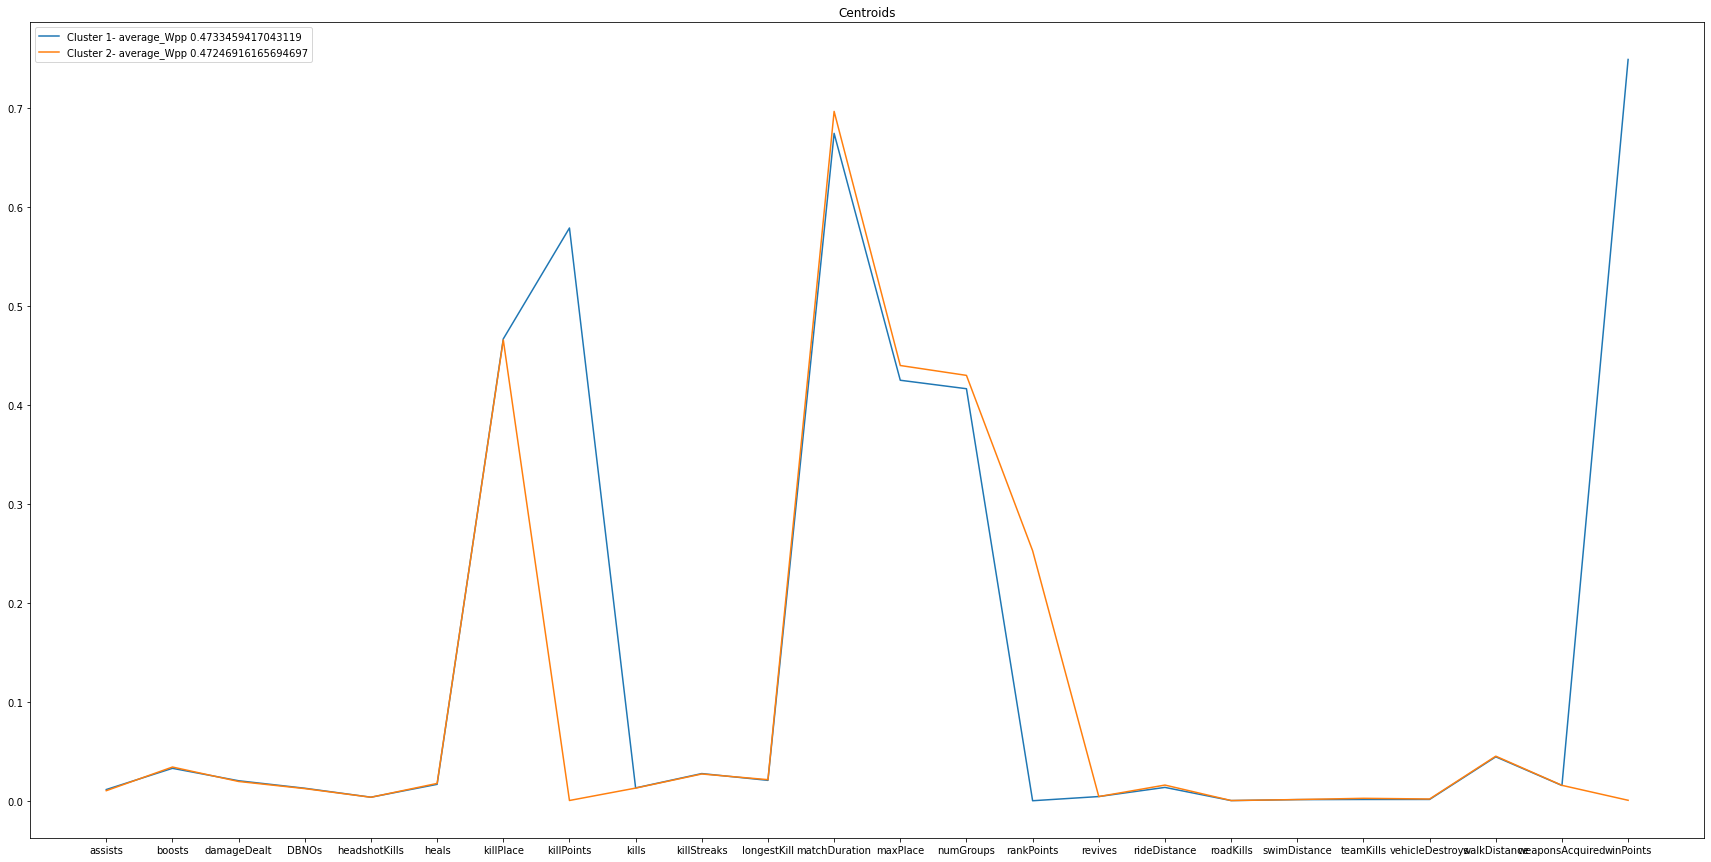

In [99]:
compare_clusters(kmeans_4,X_train_temp,y_train_temp,2)

In [100]:
centroids = get_centroids(X_train_temp,X_train,kmeans_4,6,y_train_temp)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(centroids)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,most_common,dominance,averageWpp
cluster_1,0.005333,0.010641,0.006506,2.968654e-03,0.000016,0.006767,0.701617,0.564041,0.000058,0.000196,0.000047,0.669998,0.336361,0.330954,0.000008,1.887721e-03,0.007753,7.232007e-08,0.000592,0.001127,0.000581,0.024855,0.012055,0.745090,squad-fpp,0.473096,0.312030
cluster_2,0.004400,0.010923,0.005882,3.071722e-03,0.000012,0.007191,0.701366,0.000529,0.000045,0.000156,0.000036,0.694709,0.339882,0.333575,0.249182,1.910583e-03,0.009259,1.503285e-07,0.000574,0.002209,0.000711,0.025086,0.012054,0.000824,squad-fpp,0.394833,0.305735
cluster_3,0.020304,0.055652,0.034875,2.679385e-02,0.007108,0.027993,0.226404,0.600084,0.026013,0.056302,0.041902,0.673945,0.331365,0.325859,0.000008,8.092990e-03,0.020201,2.939680e-04,0.001657,0.001706,0.002256,0.066770,0.019003,0.752401,squad-fpp,0.480280,0.629760
cluster_4,0.002924,0.031457,0.017919,1.743397e-15,0.003811,0.012232,0.471994,0.559364,0.012909,0.023973,0.019262,0.687466,0.954966,0.928333,0.000013,-1.262011e-15,0.010856,2.988821e-04,0.001299,0.000587,0.000731,0.036923,0.014986,0.749866,solo-fpp,0.683241,0.492070
cluster_5,0.002445,0.032858,0.017640,-8.769027e-15,0.003875,0.013006,0.470831,0.000216,0.012858,0.023772,0.020049,0.703594,0.949025,0.922913,0.259410,-1.386911e-15,0.011764,2.752631e-04,0.001364,0.001179,0.001020,0.037606,0.015029,0.000661,solo-fpp,0.671623,0.490293
cluster_6,0.019035,0.057750,0.033804,2.641535e-02,0.006898,0.029656,0.227135,0.000003,0.025515,0.055266,0.043132,0.695261,0.334923,0.327774,0.253285,8.206147e-03,0.024060,3.979458e-04,0.001765,0.003219,0.003123,0.068011,0.019301,0.000007,squad-fpp,0.404659,0.632442


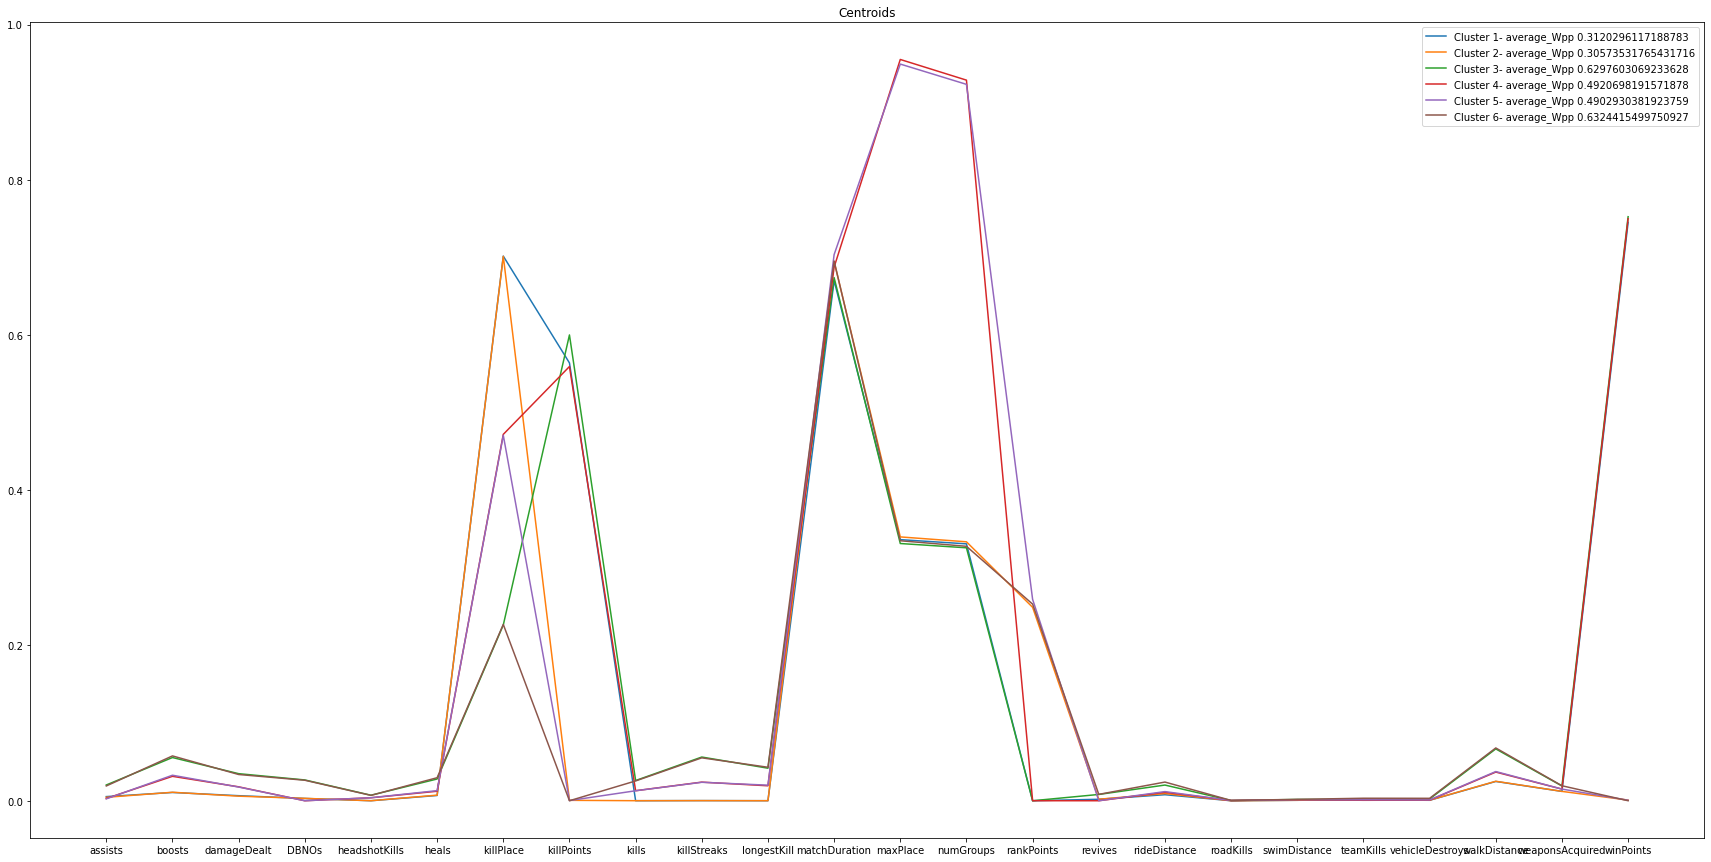

In [101]:
compare_clusters(kmeans_4,X_train_temp,y_train_temp,6)

### Cluster Analysis For Each Match Type

In [102]:
#Extract each matchType
matchType_crashfpp=train[train['matchType']=='crashfpp']
matchType_crashtpp=train[train['matchType']=='crashtpp']
matchType_duo=train[train['matchType']=='duo']
matchType_duo_fpp=train[train['matchType']=='duo-fpp']
matchType_flarefpp=train[train['matchType']=='flarefpp']
matchType_flaretpp=train[train['matchType']=='flaretpp']
matchType_normal_duo=train[train['matchType']=='normal-duo']
matchType_normal_duo_fpp=train[train['matchType']=='normal-duo-fpp']
matchType_normal_solo=train[train['matchType']=='normal-solo']
matchType_normal_solo_fpp=train[train['matchType']=='normal-solo-fpp']
matchType_normal_squad=train[train['matchType']=='normal-squad']
matchType_normal_squad_fpp=train[train['matchType']=='normal-squad-fpp']
matchType_solo=train[train['matchType']=='solo']
matchType_solo_fpp=train[train['matchType']=='solo-fpp']
matchType_squad=train[train['matchType']=='squad']
matchType_squad_fpp=train[train['matchType']=='squad-fpp']

In [103]:
#Add all match types to a list
allTypes = [matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo_fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal_duo,matchType_normal_duo_fpp,matchType_normal_solo,matchType_normal_solo_fpp,matchType_normal_squad,matchType_normal_squad_fpp,matchType_solo,matchType_solo_fpp,matchType_squad,matchType_squad_fpp]

#Add all names of match types to a list
names = ["crashfpp","crashtpp","duo","duo_fpp","flarefpp","flaretpp","normal_duo","normal_duo_fpp","normal_solo","normal_solo_fpp","normal_squad","normal_squad_fpp","solo","solo_fpp","squad","squad_fpp"]

In [104]:
for index in range(len(allTypes)):
    #Reset the indices
    allTypes[index] = allTypes[index].reset_index(drop=True)

In [105]:
kmeans = KMeans(random_state=0,n_init = 50) 

#### View the best number of clusters

crashfpp:
n_clusters:  2 ,Score:  8671.747543226787 ,Average WPP:  [0.6509074186682882, 0.2814120080053369]
n_clusters:  3 ,Score:  7349.923338726254 ,Average WPP:  [0.7057865871121718, 0.5309915284625728, 0.16381575726670067]
n_clusters:  4 ,Score:  5987.304389933077 ,Average WPP:  [0.7068755604155276, 0.5318276126558007, 0.15597064413938752, 0.60006589958159]
n_clusters:  5 ,Score:  5503.748570734683 ,Average WPP:  [0.7461607575757575, 0.5947939100346021, 0.11270614449696151, 0.5574489878542511, 0.451067032967033]
n_clusters:  6 ,Score:  5174.62644207231 ,Average WPP:  [0.1062804516584333, 0.7284614506927466, 0.5877143165467626, 0.42227804214819853, 0.8122152777777778, 0.5426603238866398]
n_clusters:  7 ,Score:  4888.070323206304 ,Average WPP:  [0.6374676100628931, 0.811405035971223, 0.10610909732016924, 0.586717441860465, 0.4517496703296703, 0.7275145559210526, 0.3074066455696203]
n_clusters:  8 ,Score:  4780.502271214008 ,Average WPP:  [0.7524466042154566, 0.32623773747841106, 0.30

flaretpp:
n_clusters:  2 ,Score:  2448.631125549769 ,Average WPP:  [0.4345421431787483, 0.4349760563380282]
n_clusters:  3 ,Score:  4235.928724452476 ,Average WPP:  [0.2408252268602541, 0.6253160857908847, 0.4349760563380282]
n_clusters:  4 ,Score:  4065.6370741470073 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.4349760563380282, 0.5018183673469389]
n_clusters:  5 ,Score:  3717.1578034177887 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.583208904109589, 0.5018183673469389, 0.27815]
n_clusters:  6 ,Score:  3522.0420871051674 ,Average WPP:  [0.10618742424242424, 0.4525469111969112, 0.583208904109589, 0.5245916256157636, 0.27815, 0.7860341013824883]
n_clusters:  7 ,Score:  3276.877998330792 ,Average WPP:  [0.06286973094170403, 0.4172489539748954, 0.583208904109589, 0.2767777041942605, 0.27815, 0.7977825552825554, 0.6580215102974828]
n_clusters:  8 ,Score:  3029.1729156746846 ,Average WPP:  [0.2770691629955947, 0.5916312056737589, 0.3243996932515337, 0.6660899521

n_clusters:  3 ,Score:  488.32371214479963 ,Average WPP:  [0.5495595419847328, 0.5379620689655172, 0.4466440366972477]
n_clusters:  4 ,Score:  431.93765662884 ,Average WPP:  [0.4662683333333334, 0.5379620689655172, 0.5030526315789474, 0.7518714285714287]
n_clusters:  5 ,Score:  419.8143285732483 ,Average WPP:  [0.4662683333333334, 0.5307504672897196, 0.5030526315789474, 0.7518714285714287, 0.5582684210526315]
n_clusters:  6 ,Score:  431.4803879123093 ,Average WPP:  [0.5346647058823529, 0.5307504672897196, 0.7614657894736843, 0.5582684210526315, 0.3568275862068966, 0.5019131147540983]
n_clusters:  7 ,Score:  423.00336306524696 ,Average WPP:  [0.48596699029126206, 0.5307504672897196, 0.5581594594594594, 0.5582684210526315, 0.7616878787878788, 0.34582599999999997, 0.530481081081081]
n_clusters:  8 ,Score:  415.4960784412743 ,Average WPP:  [0.4911988764044944, 0.5307504672897196, 0.3578352941176471, 0.6566294117647059, 0.5582684210526315, 0.7360260869565217, 0.47547976190476193, 0.55267808

n_clusters:  10 ,Score:  759141.6064315895 ,Average WPP:  [0.5270444044096227, 0.5226588881544866, 0.6996939322980855, 0.6857867662659124, 0.1393685245649752, 0.14687623906008387, 0.16178045692974743, 0.6962159689161554, 0.5300487726149049, 0.5105974027439301]
best_n_clusters:  2 , best_score:  1289948.003485198 , best_average_Wpp:  [0.4529095417843363, 0.45123709279262936] 

squad_fpp:
n_clusters:  2 ,Score:  3890983.6151302313 ,Average WPP:  [0.4654673331482458, 0.46381464269664135]
n_clusters:  3 ,Score:  3223621.1459085806 ,Average WPP:  [0.4638196056165469, 0.30687071163571067, 0.6263034422294205]
n_clusters:  4 ,Score:  3578818.760066495 ,Average WPP:  [0.3114743191175266, 0.30604566035874264, 0.6264920452575082, 0.6201321412892071]
n_clusters:  5 ,Score:  3182859.510117304 ,Average WPP:  [0.7001543521116671, 0.6206288031896238, 0.17264619752645105, 0.30960051438500613, 0.5364799723234172]
n_clusters:  6 ,Score:  2943467.325756722 ,Average WPP:  [0.7002601409170516, 0.53601548385

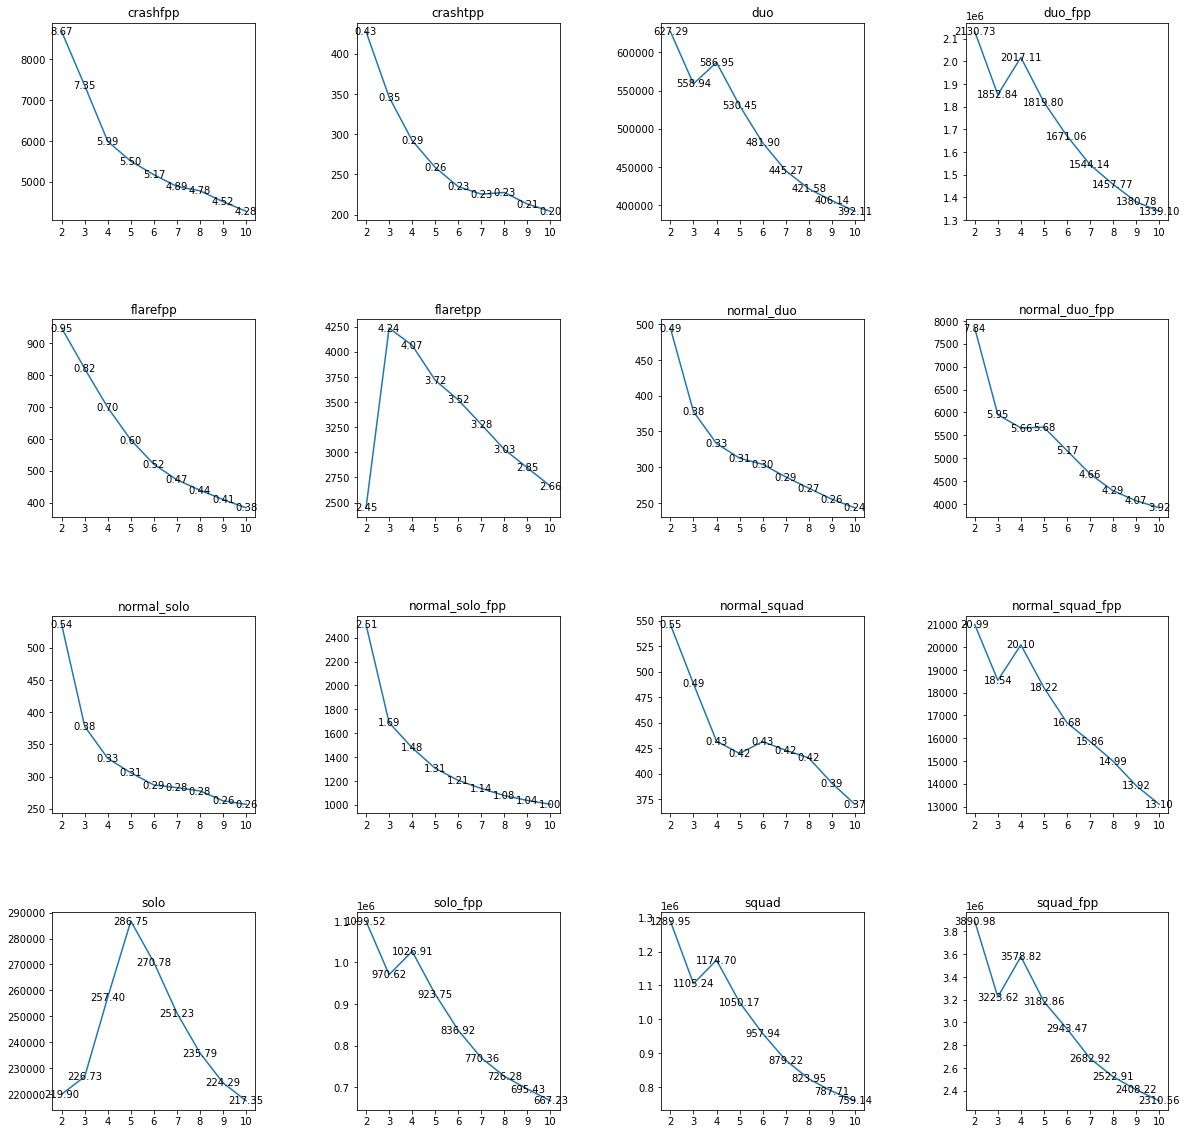

In [23]:
plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace=.5,wspace=.5)

#Used to allocate position for sub plots
p = 1

#Used to store the best number of clusters for each type
n_clusters_collection = []

for index in range(len(allTypes)):
    
    #Get the name
    name = names[index]
    
    #Get the dataframe with specific type, without changing the original data
    single_type = allTypes[index].copy()
    
    #Extract X and y
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    
    #Delete matchType column
    single_X_temp = single_X.drop(["matchType"],axis=1)
    
    #Convert numpy array to pandas dataframe
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y})
    
    scores = []
    Xs = []

    best_n_clusters = 0
    best_score = 0
    best_average_Wpp = 0
    print(name+":")
    for i in range(2,11):   
        
        #Set the number of clusters
        kmeans.n_clusters = i
        
        #Train the kmeans
        kmeans.fit(single_X_temp)
        
        #Get the score
        score = metrics.calinski_harabasz_score(single_X_temp,kmeans.labels_)
        
        #Add a cluster column
        single_X_temp["cluster"] = kmeans.labels_
        single_y_temp["cluster"] = kmeans.labels_
        
        #Calculate the average WPP
        average_Wpp = getAverageWPP(single_y_temp,i)
        
        #If current score is larger than the best score, then replace the values
        if(score>best_score):
            best_score = score
            best_n_clusters = i
            best_average_Wpp = average_Wpp
            
        print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
        
        #Append X and scores with current value
        Xs.append(i)
        scores.append(score)
        
        #Delete the cluster column
        single_X_temp = single_X_temp.drop(["cluster"],axis=1) 
        single_y_temp = single_y_temp.drop(["cluster"],axis=1) 

    print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp,"\n")
    
    #Append the best n_clusters
    n_clusters_collection.append(best_n_clusters)
    
    #Plot the line
    ax = plt.subplot(4,4,p)
    for x,y in zip(Xs,scores):
        ax.text(x,y,'%.2f'%(y*0.001),ha='center',va='center')
    plt.xticks(Xs)
    ax.plot(Xs,scores)
    ax.set_title(name)
    p+=1
    
plt.savefig("Individual_analysis.png")
plt.show()

#### Distinguish 2 clusters and no clusters 

In [107]:
types_with_two = [matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo_fpp,matchType_flarefpp,matchType_normal_duo,matchType_normal_duo_fpp,matchType_normal_solo,matchType_normal_solo_fpp,matchType_normal_squad,matchType_normal_squad_fpp,matchType_solo_fpp,matchType_squad,matchType_squad_fpp]

#Add all names of match types to a list
names_with_two = ["crashfpp","crashtpp","duo","duo_fpp","flarefpp","normal_duo","normal_duo_fpp","normal_solo","normal_solo_fpp","normal_squad","normal_squad_fpp","solo_fpp","squad","squad_fpp"]

##### From the results, I think most of them have 2 clusters except crashtpp, normal_duo, but maybe I'm wrong.

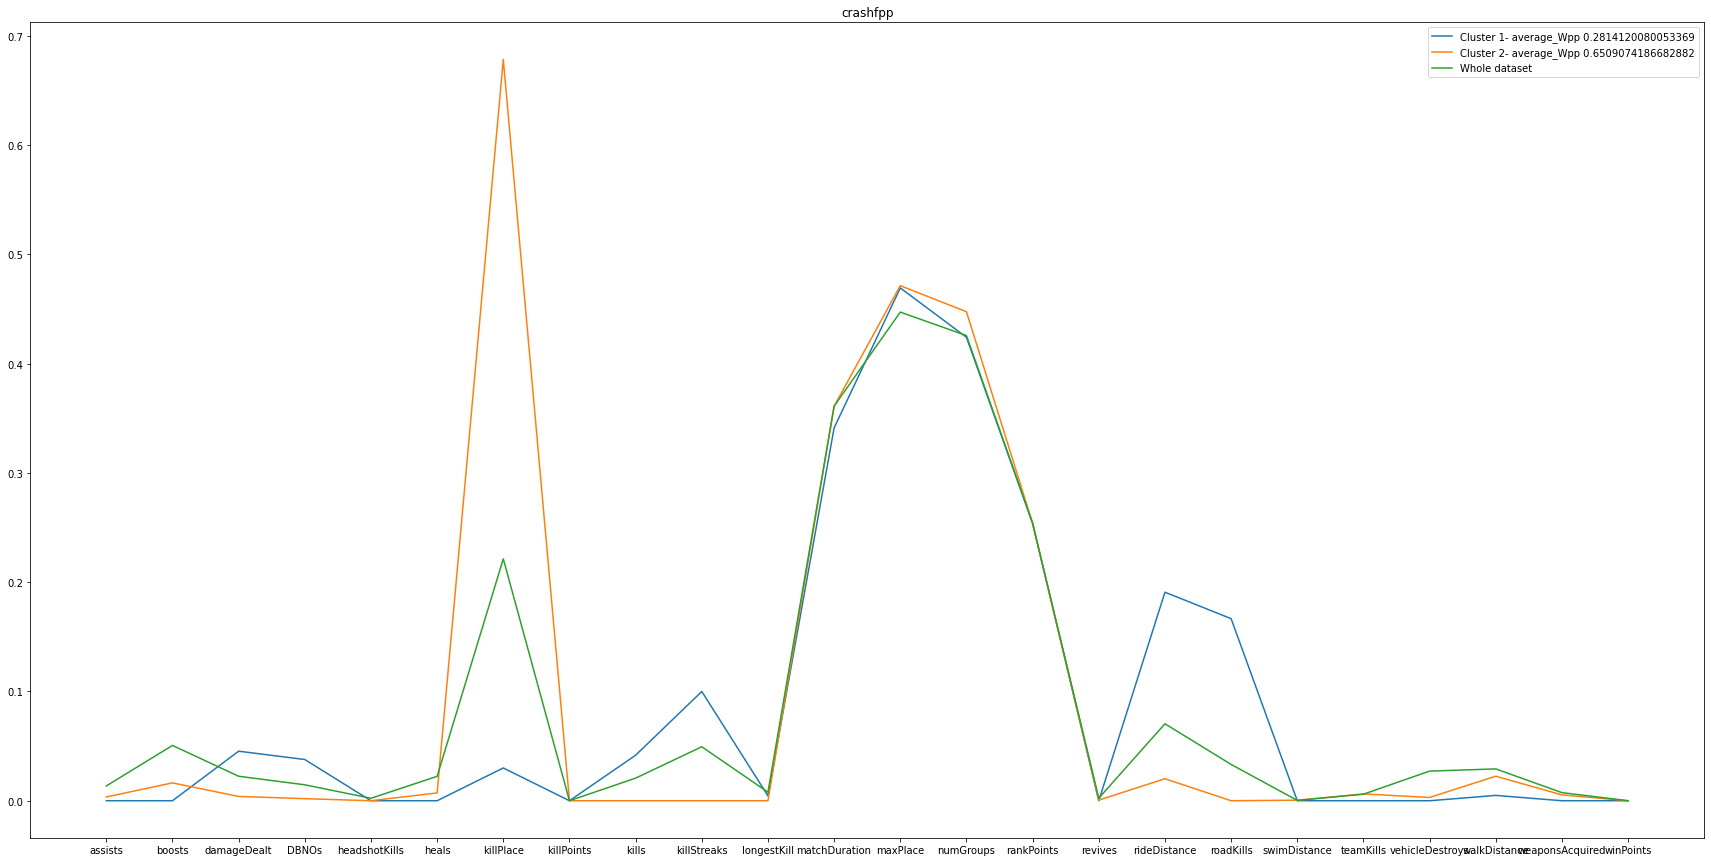

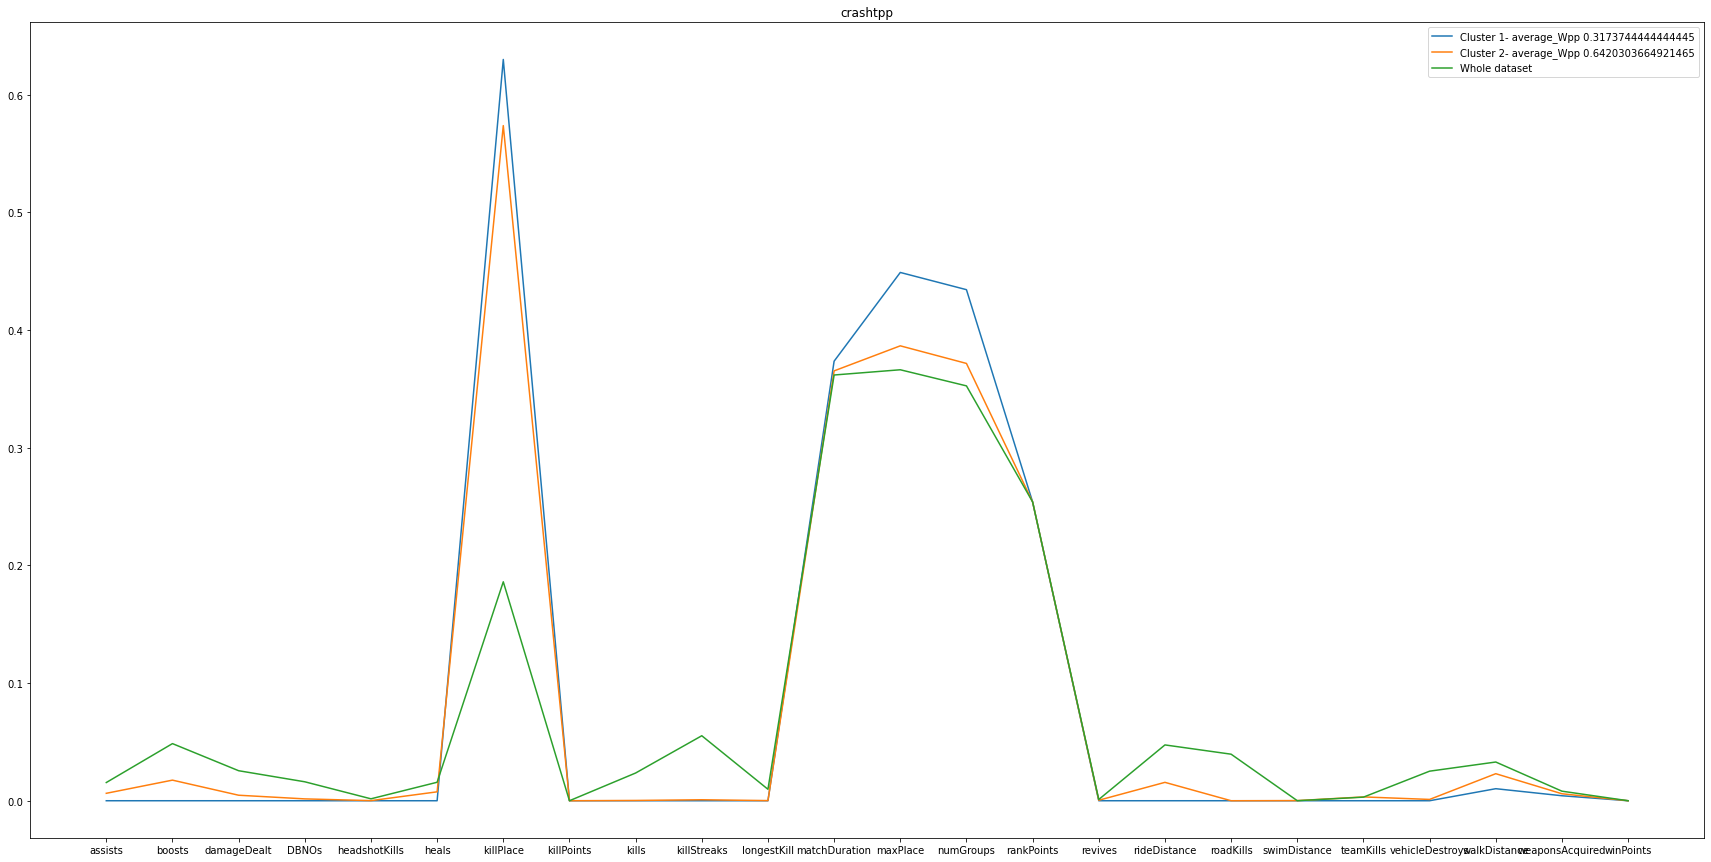

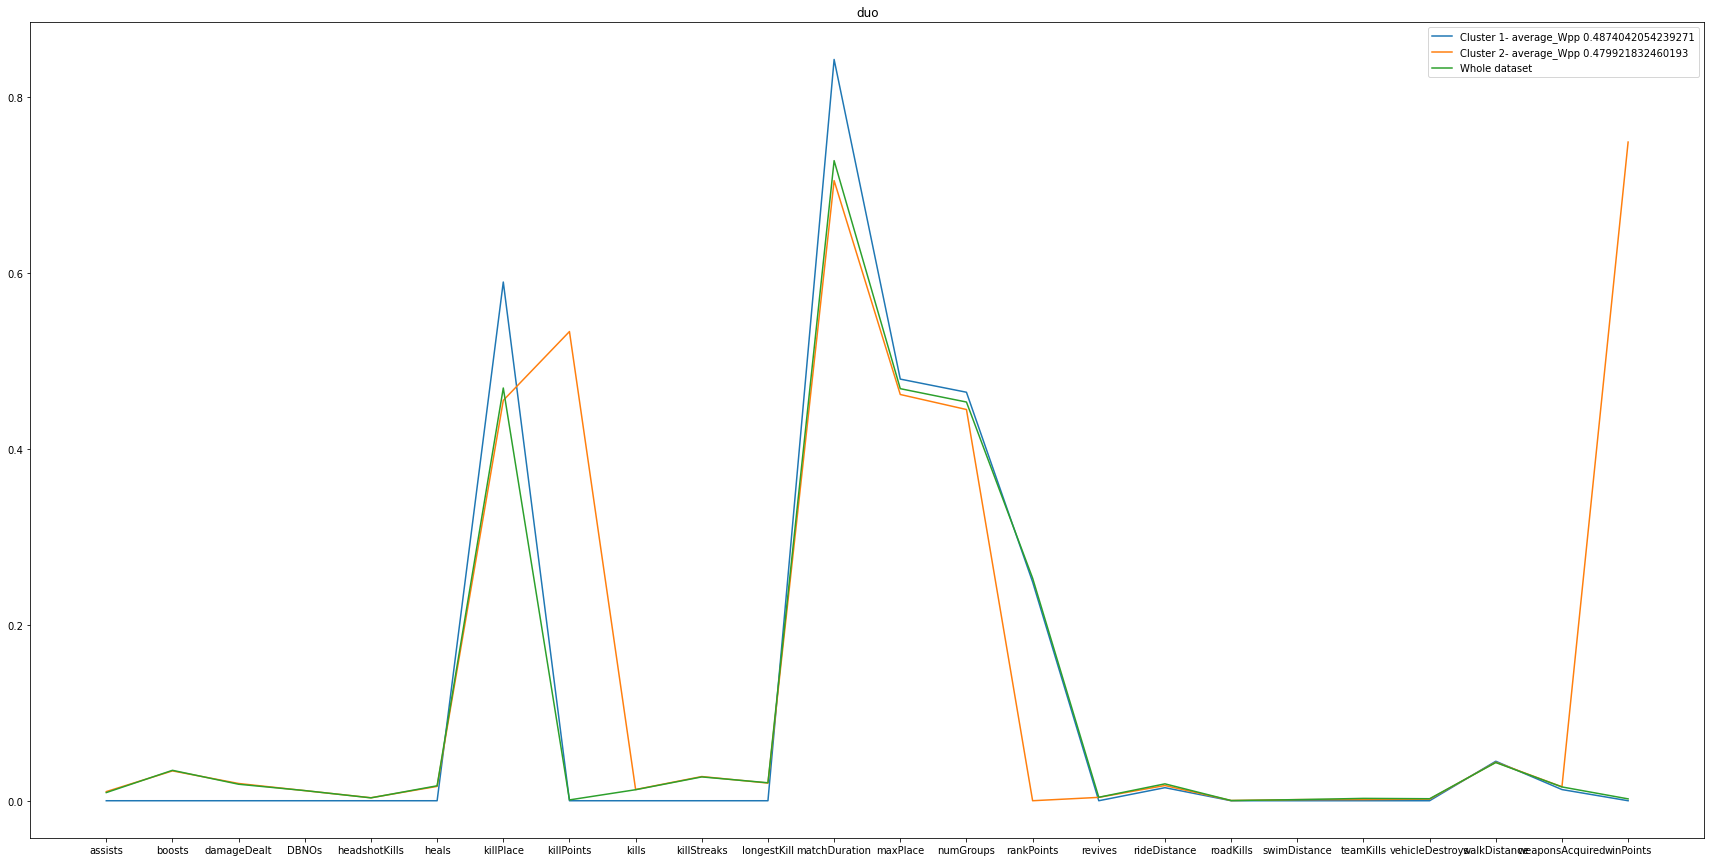

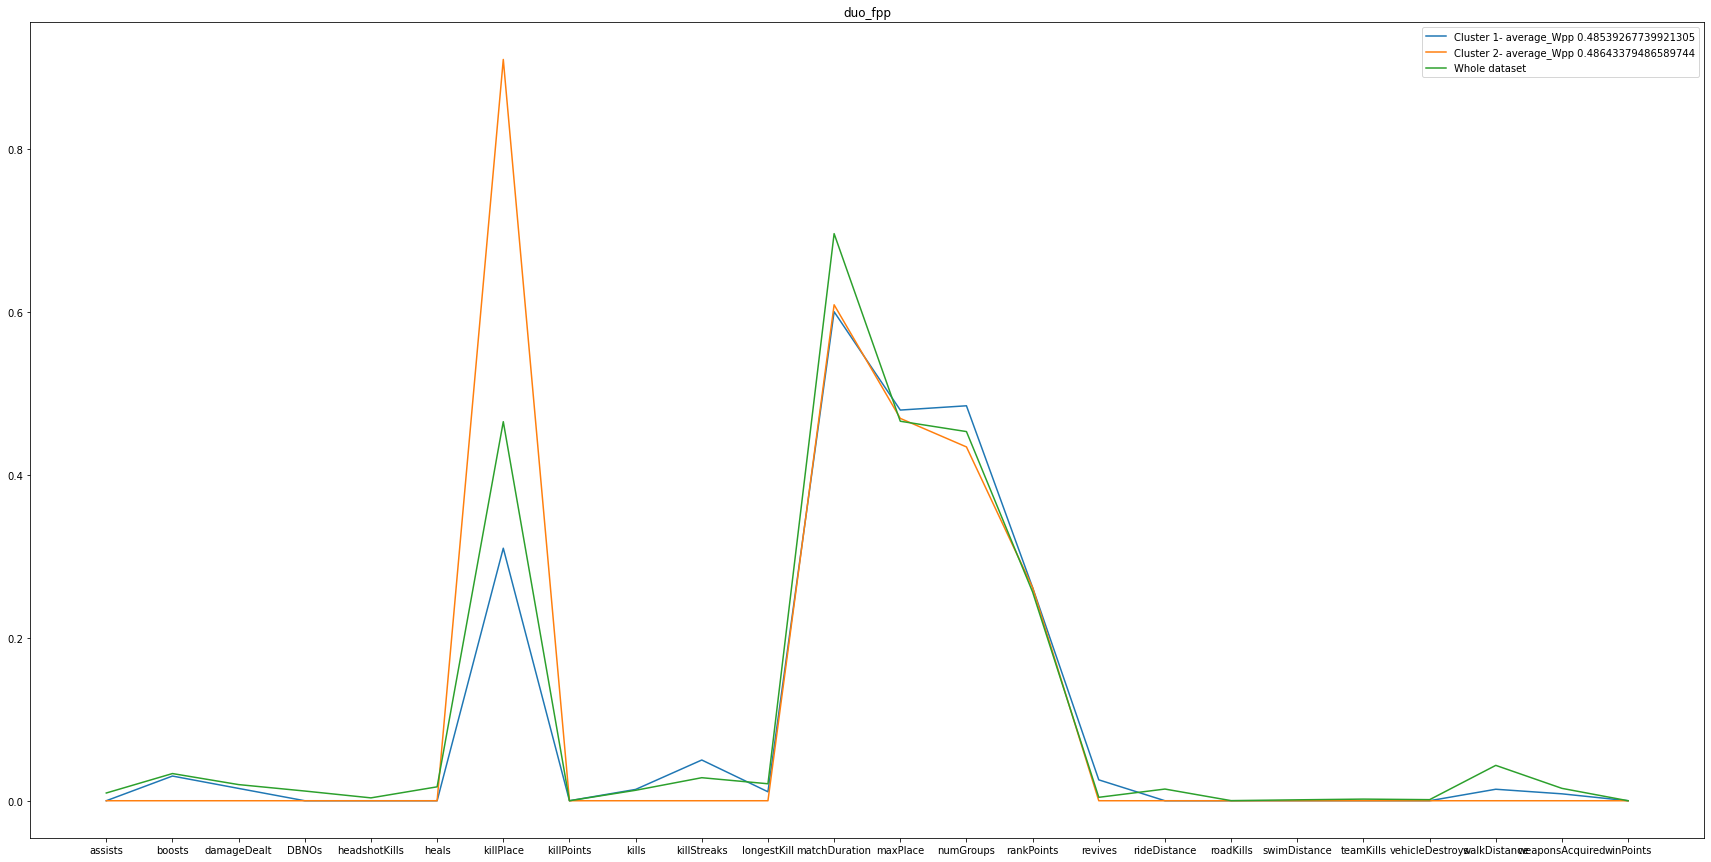

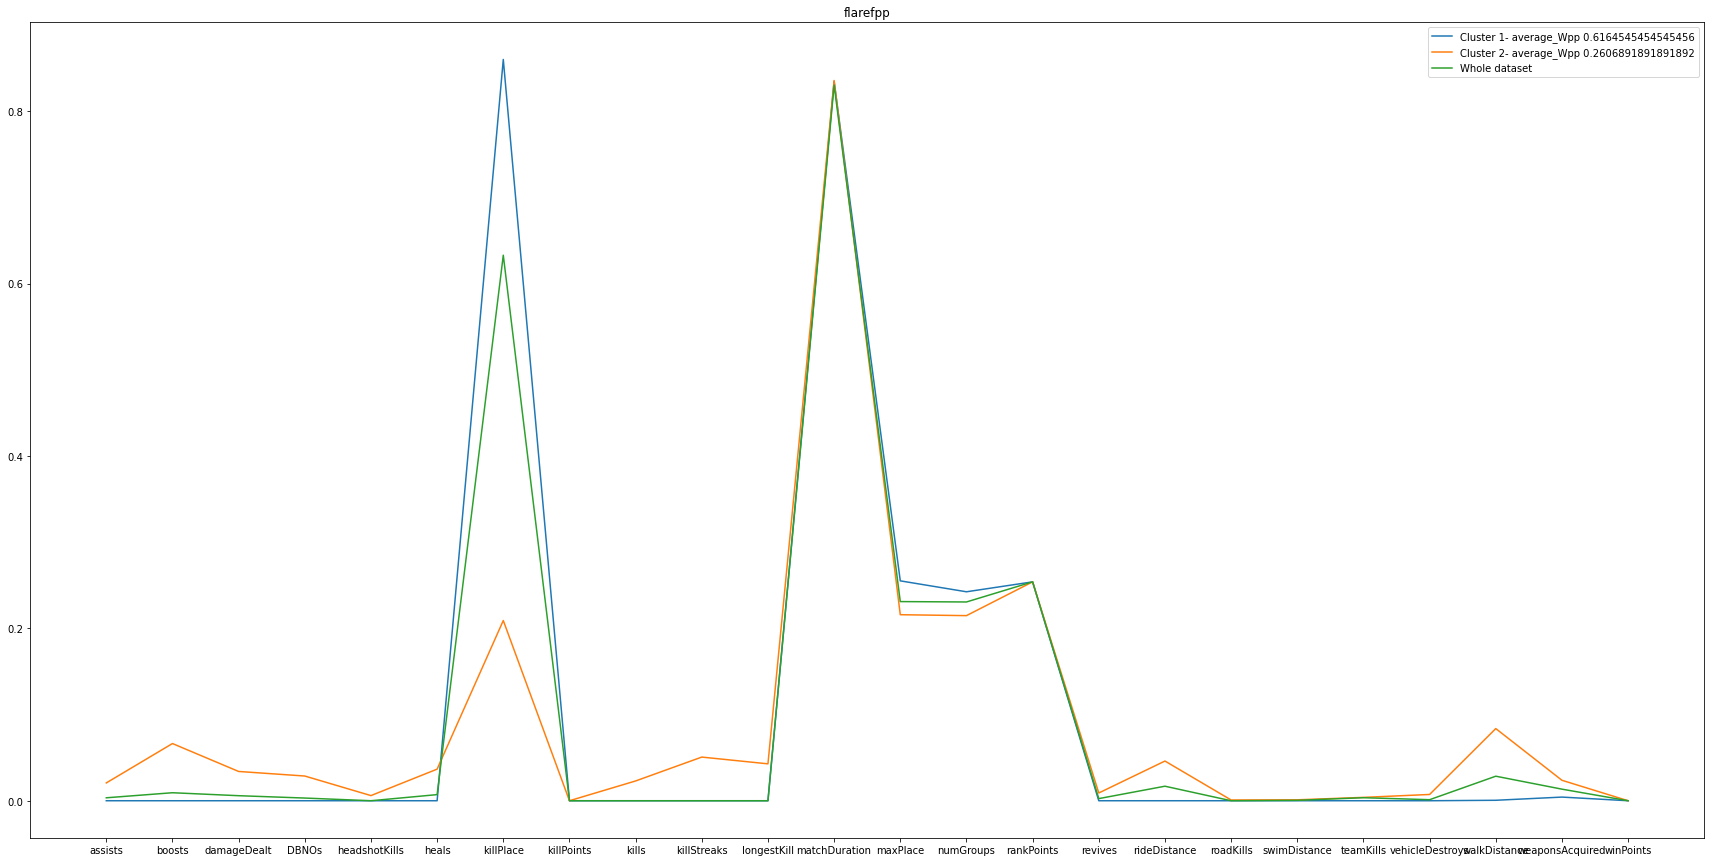

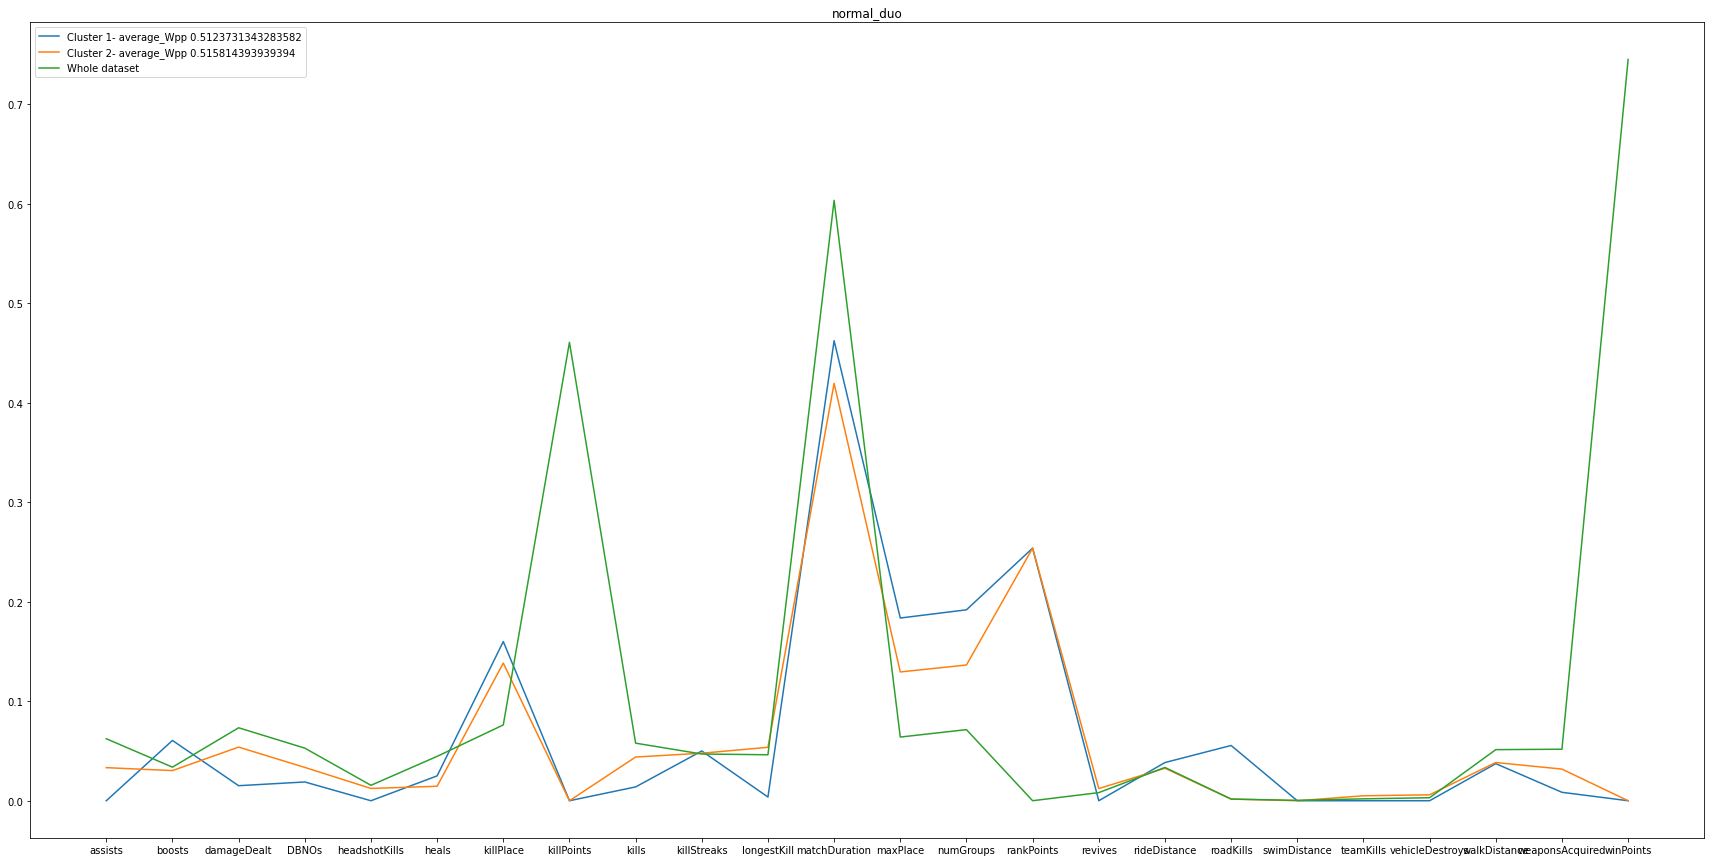

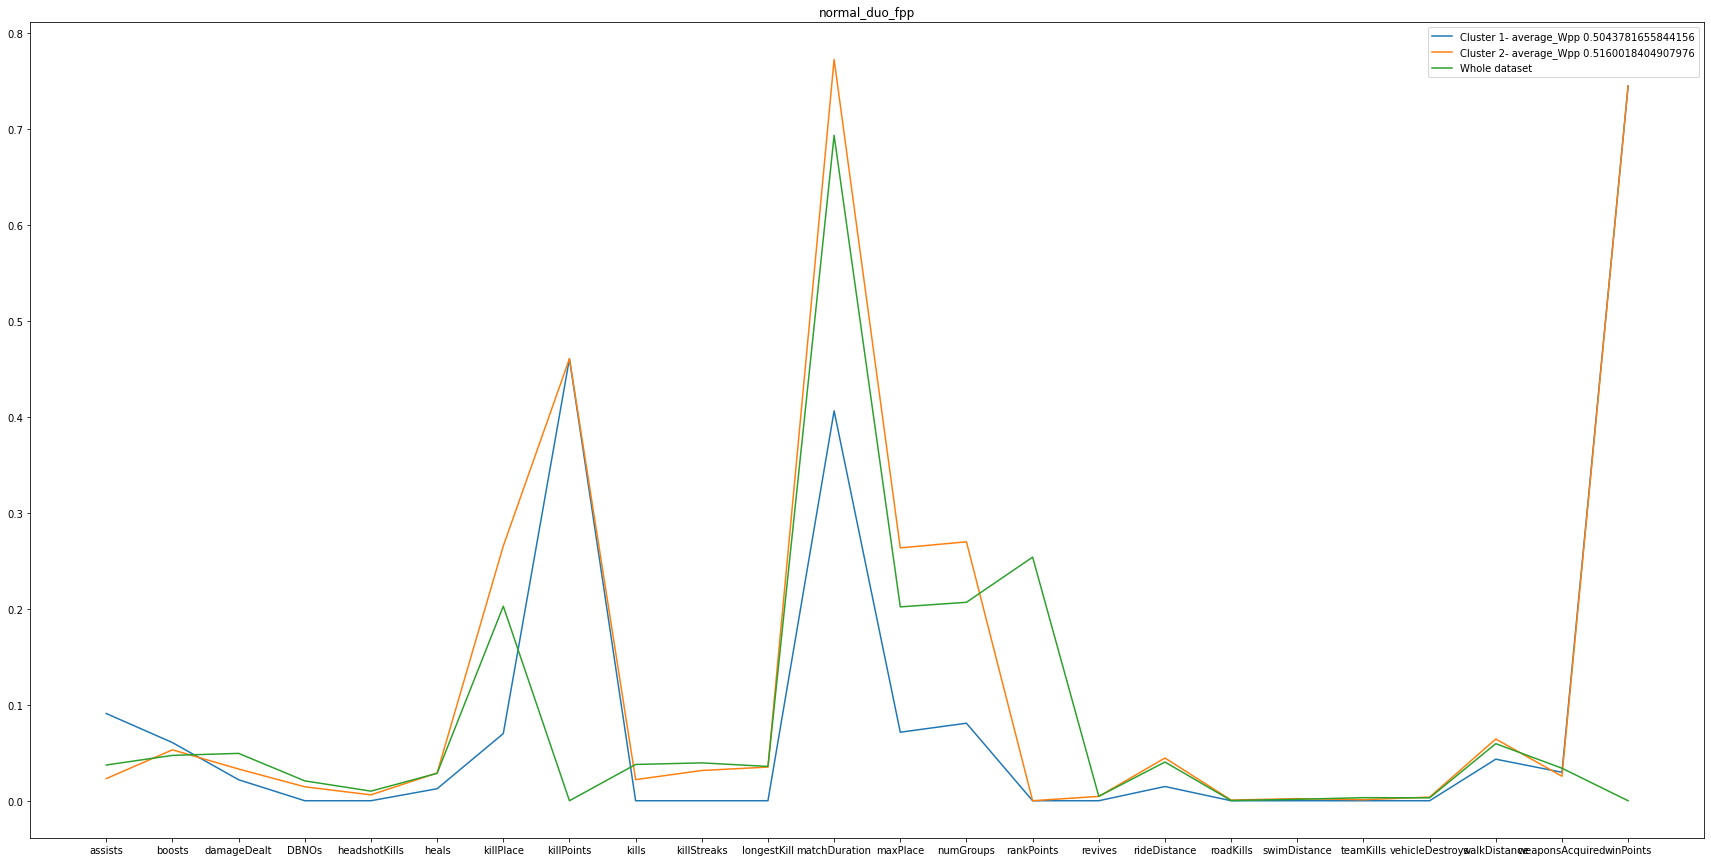

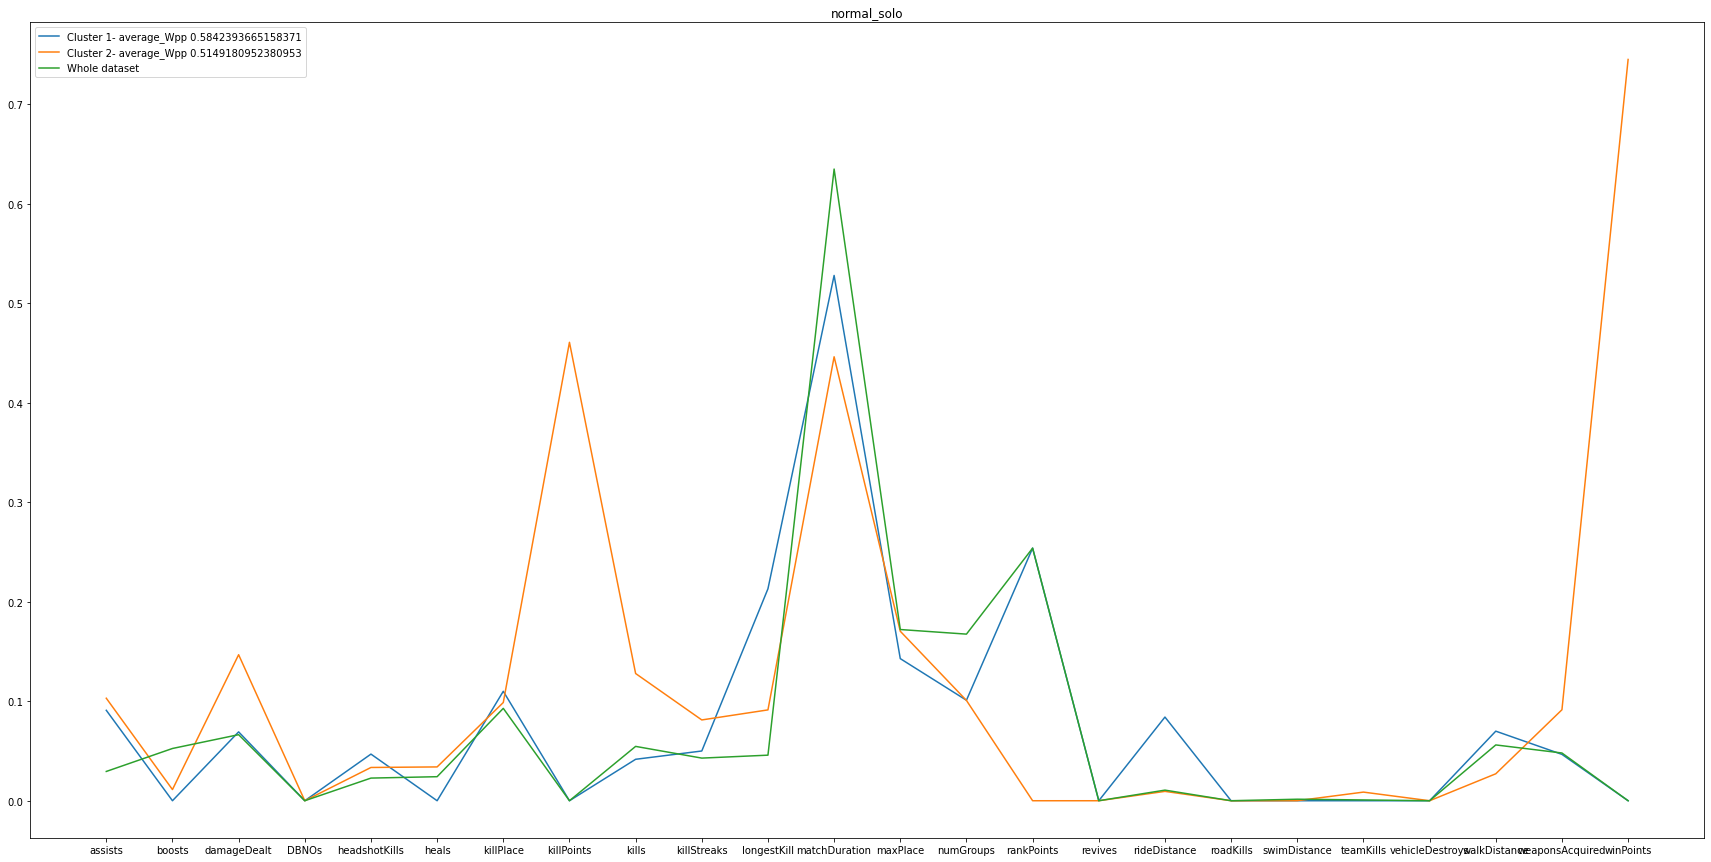

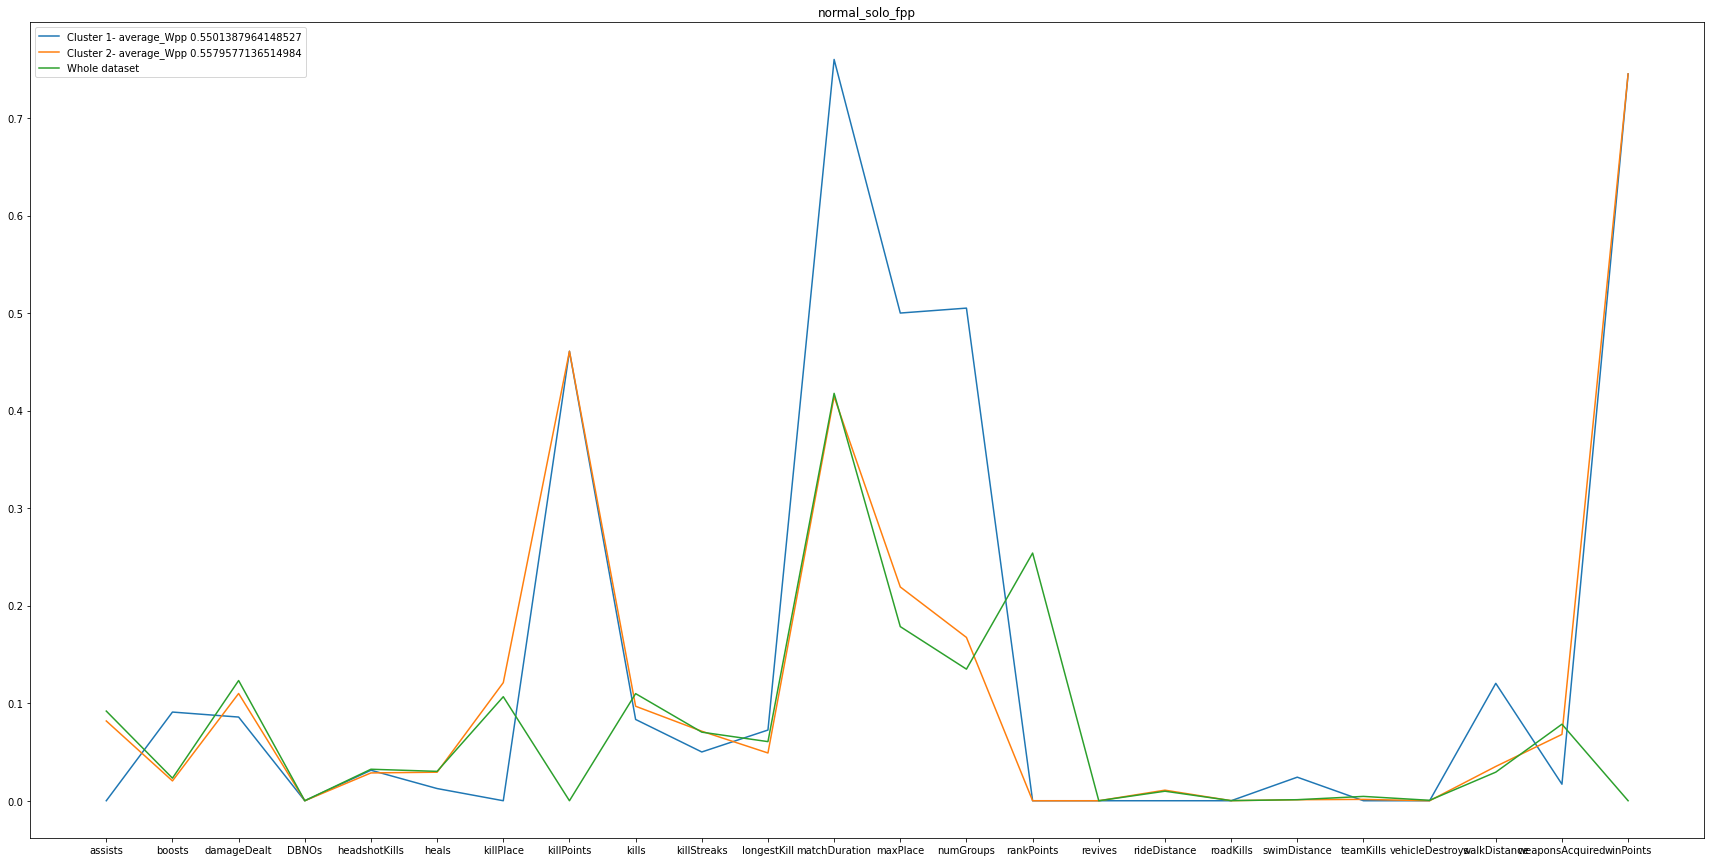

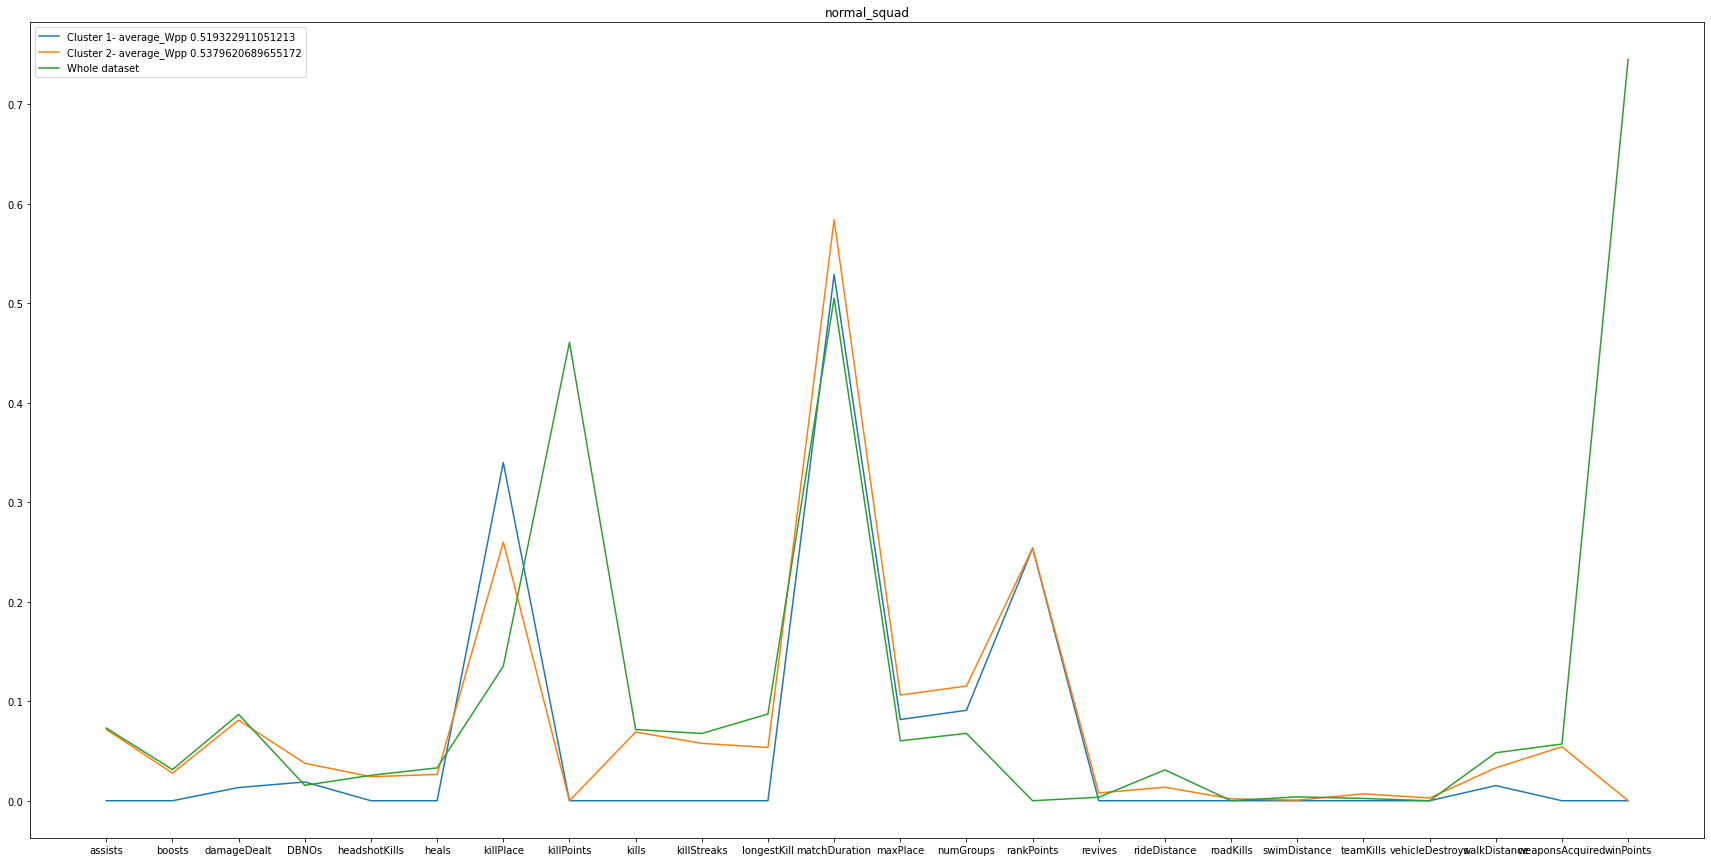

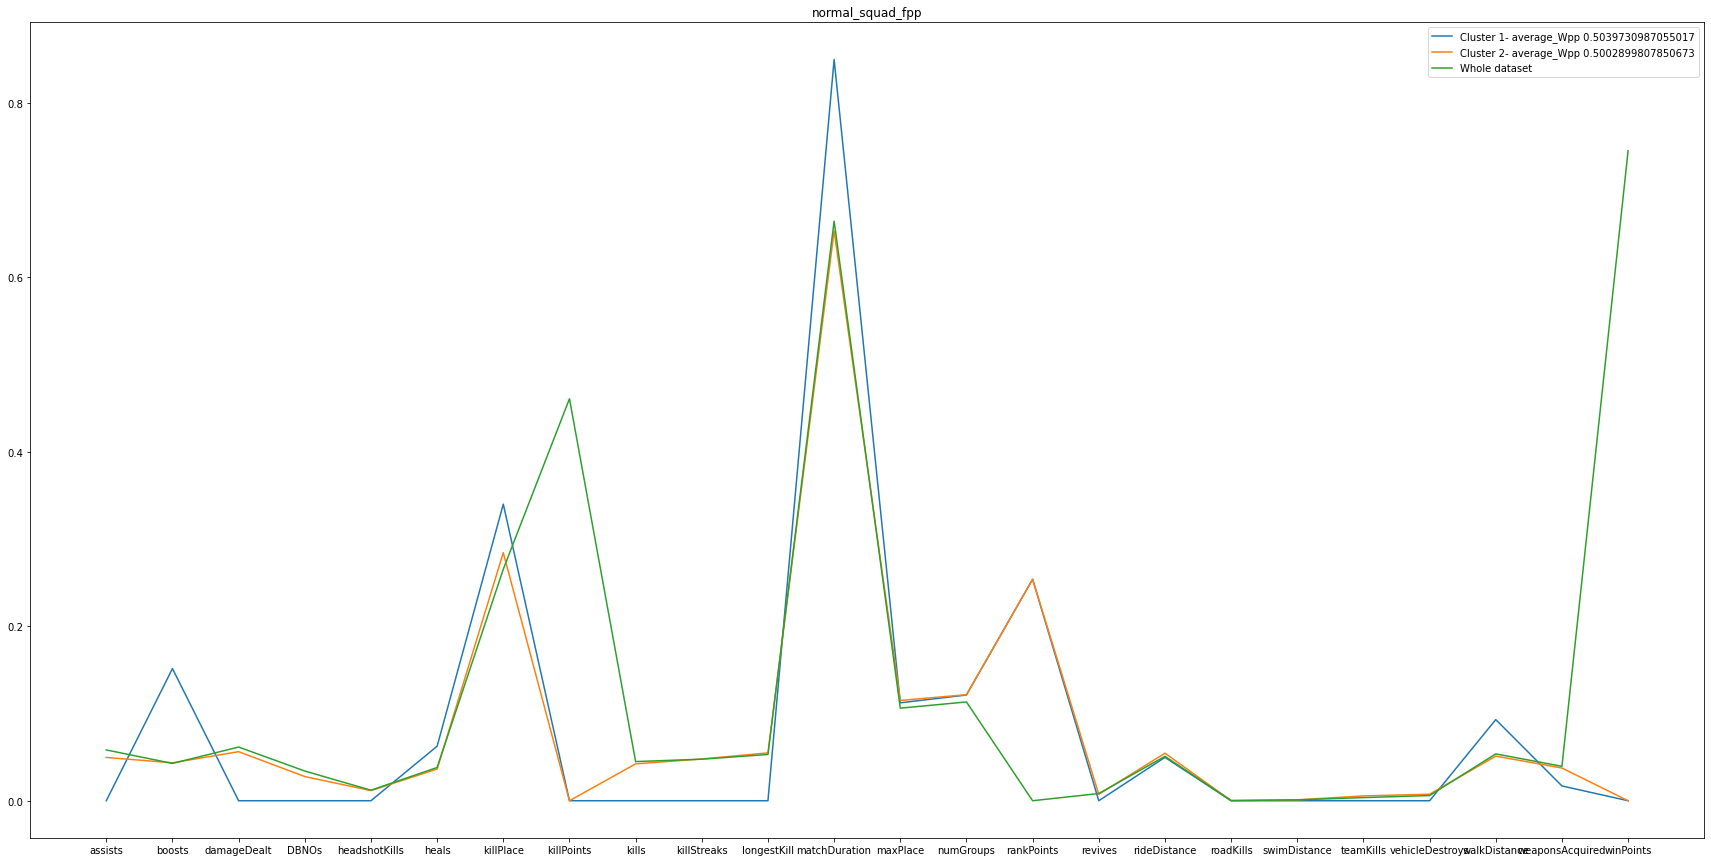

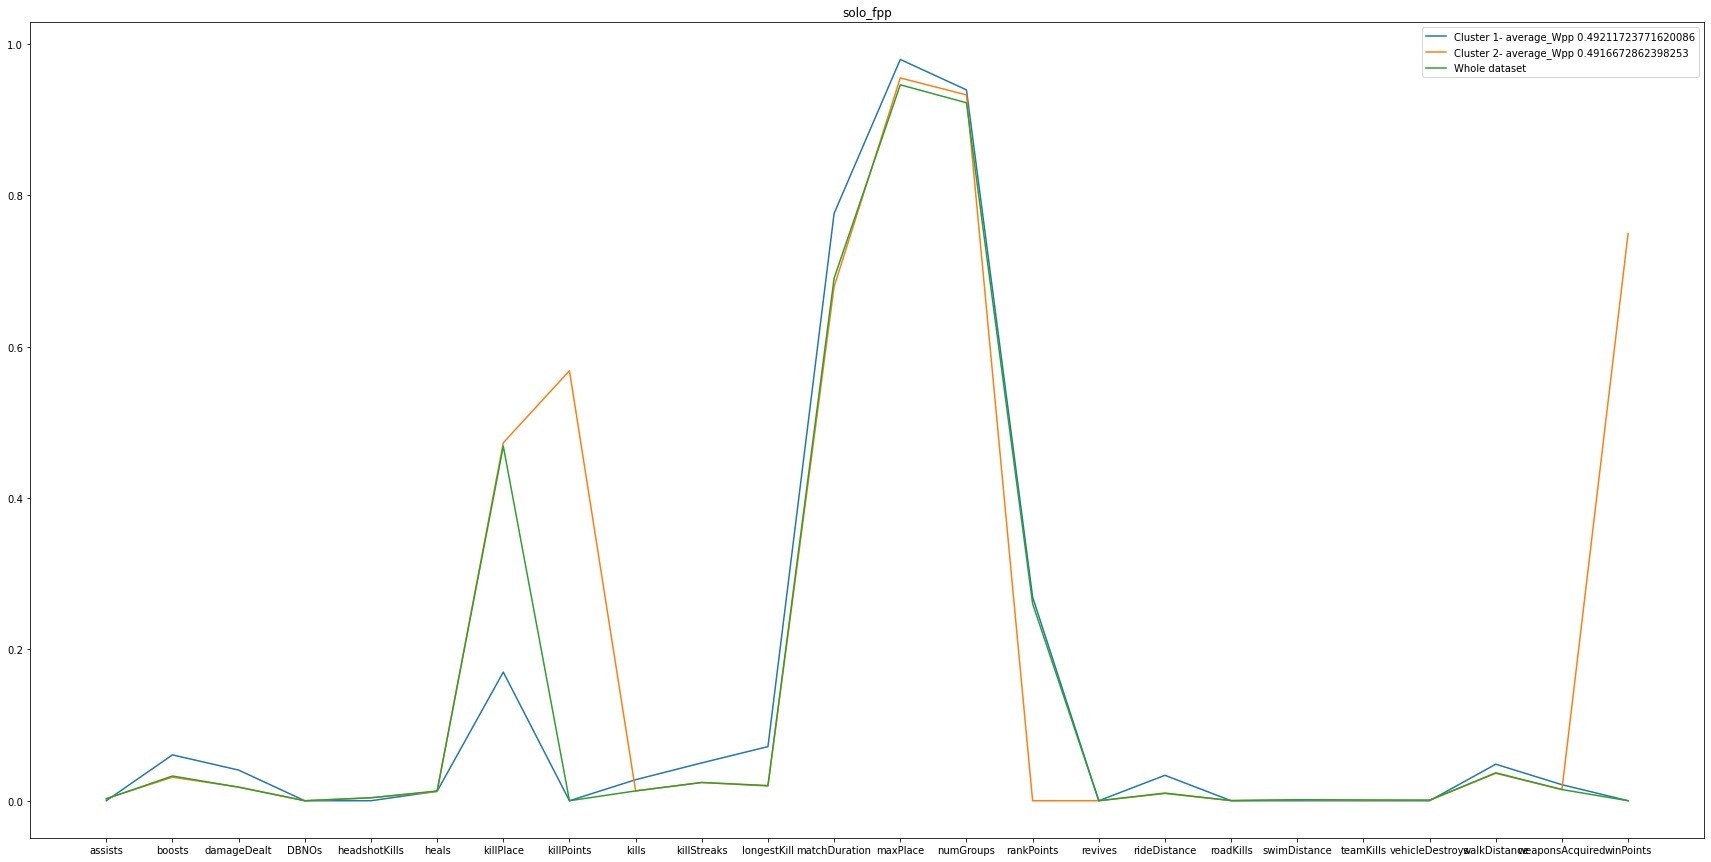

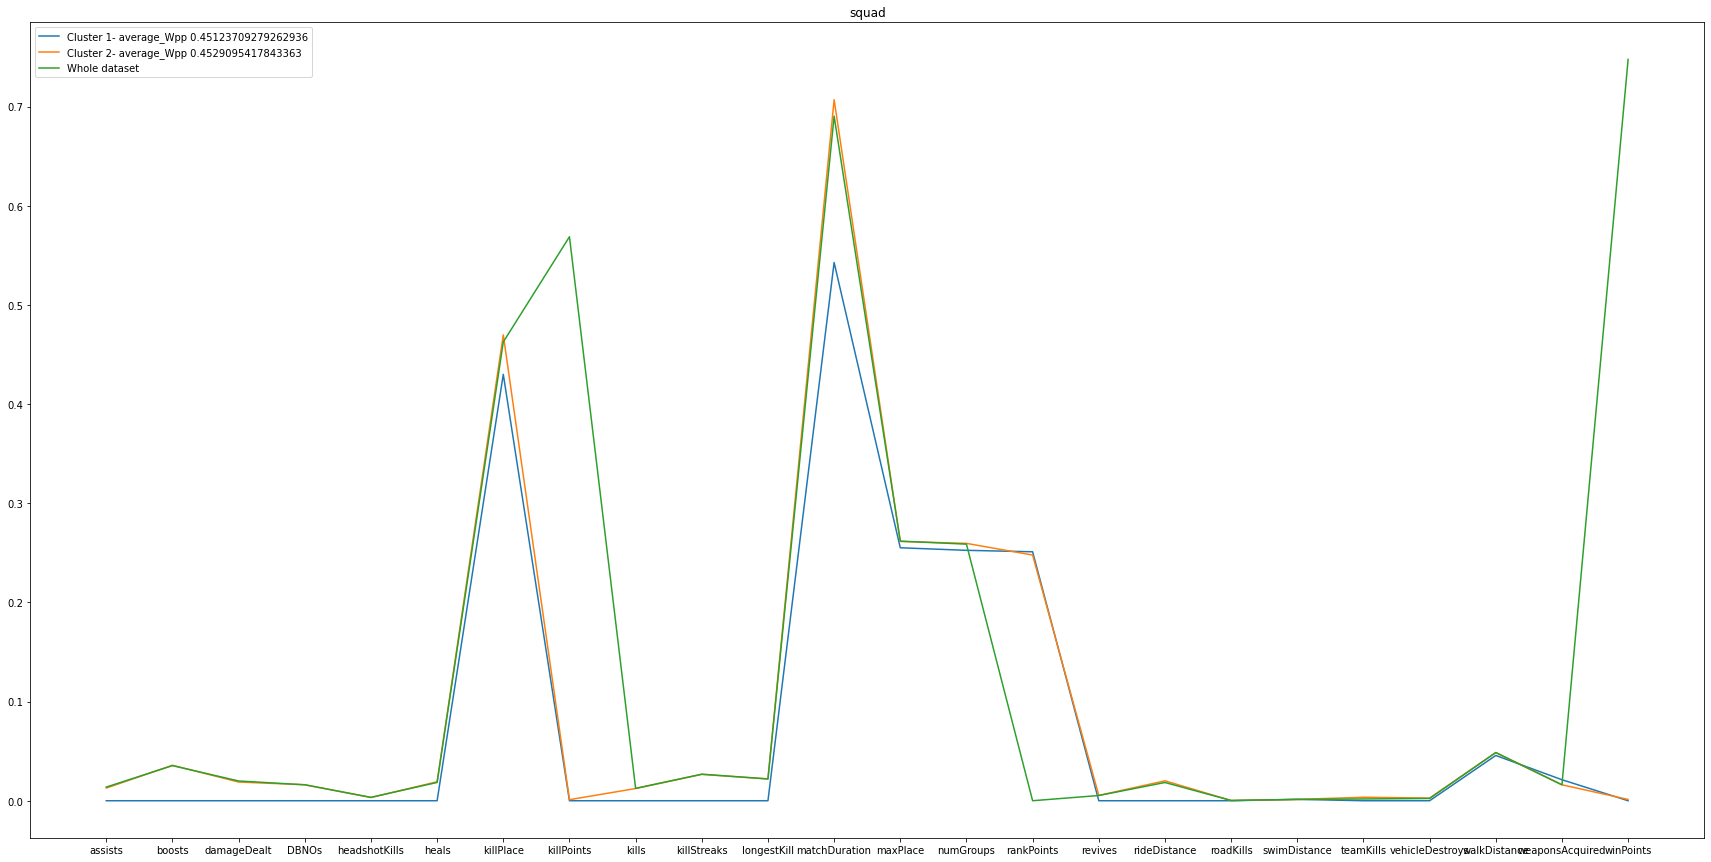

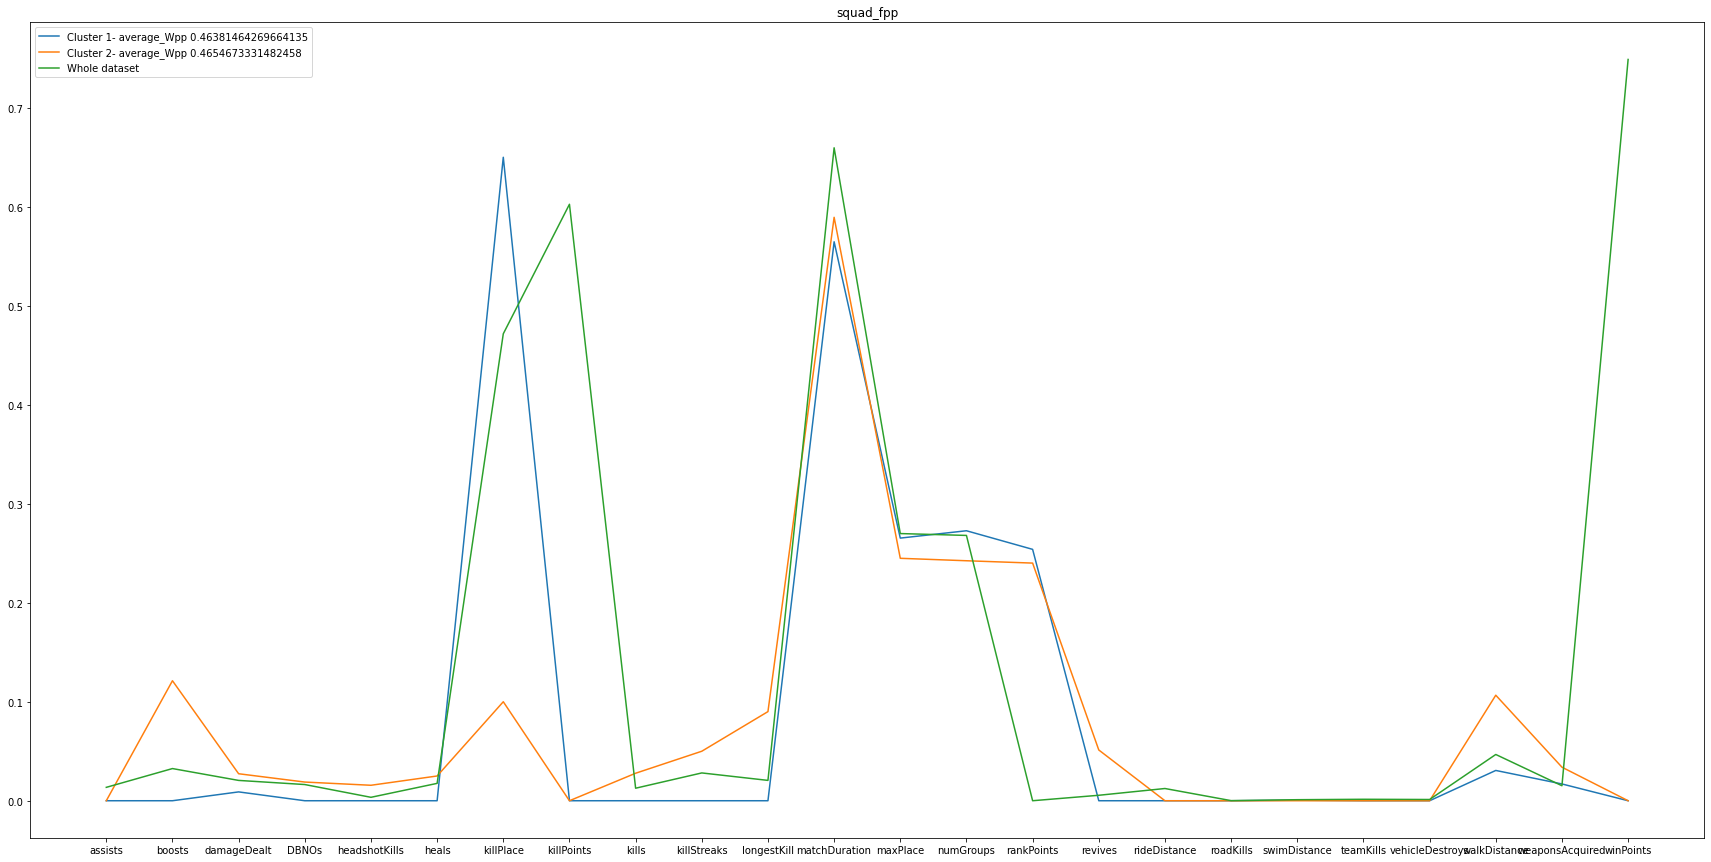

In [110]:
for i in range(len(types_with_two)):
    #Get the name
    name = names_with_two[i]
    
    #Get the dataframe with specific type, without changing the original data
    single_type = types_with_two[i].copy()
    
    #Extract X and y
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    
    #Delete matchType column
    single_X_temp = single_X.drop(["matchType"],axis=1)
    
    #Convert numpy array to pandas dataframe
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y})
    
    distinguish_clusters(kmeans,single_X_temp,single_y_temp,2,name)

#### View the centroids 

In [32]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = n_clusters_collection[index]
    single_type = allTypes[index].copy()
    
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        display(get_average(single_X_temp,kmeans,n_clusters,single_y_temp))

crashfpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
6287,0.013520,0.050625,0.022407,0.014593,2.257261e-03,0.022312,0.221411,0.0,2.068971e-02,4.940693e-02,7.813479e-03,0.361194,0.447273,0.425769,0.253933,0.002355,0.070442,3.323533e-02,0.000305,0.005981,0.027129,0.029140,0.007417,0.0,0.650907
6288,0.003456,0.016359,0.003960,0.001913,-3.252607e-18,0.007173,0.678520,0.0,2.255141e-17,4.857226e-17,1.994932e-17,0.361085,0.471460,0.447627,0.253933,0.000556,0.020125,3.816392e-17,0.000512,0.006224,0.003001,0.022463,0.005358,0.0,0.281412


crashtpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
371,0.006313,0.017508,0.004685,0.001572,0.000087,0.007569,0.573778,0.0,0.000231,0.000833,0.000111,0.365339,0.386621,0.371661,0.253933,0.000427,0.015627,2.775558e-17,0.000117,0.003241,0.001111,0.022984,0.005932,0.0,0.317374
372,0.015469,0.048548,0.025512,0.016102,0.001636,0.015707,0.186073,0.0,0.023560,0.055236,0.009732,0.361831,0.366278,0.352583,0.253933,0.001074,0.047435,3.955788e-02,0.000039,0.003054,0.025131,0.032906,0.008120,0.0,0.642030


duo


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
313591,0.009278,0.034605,0.018765,0.011544,0.003278,0.016999,0.469445,0.000939,0.012535,0.027103,0.020435,0.728074,0.468702,0.453503,0.253211,0.003933,0.019212,0.000226,0.001241,0.002676,0.002286,0.043451,0.015707,0.002107,0.479922
313592,0.010417,0.033931,0.019625,0.011481,0.003392,0.016314,0.455402,0.533653,0.012733,0.027521,0.020085,0.705335,0.462069,0.444995,0.000010,0.003831,0.017297,0.000254,0.001286,0.001382,0.001762,0.043804,0.015844,0.749190,0.487404


duo_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
996691,0.009497,0.033361,0.019814,0.011910,0.003512,0.017078,0.465323,-1.165179e-13,0.012842,0.028275,0.020831,0.696170,0.465883,0.453184,0.256219,0.004200,0.014343,0.000116,0.001114,0.001995,0.001320,0.043414,0.015186,-3.029799e-13,0.485393
996692,0.010292,0.031593,0.020260,0.011784,0.003521,0.015887,0.468037,5.700422e-01,0.012894,0.028433,0.019869,0.673049,0.467522,0.457131,0.000008,0.004073,0.011995,0.000107,0.001060,0.001025,0.000939,0.041947,0.014975,7.493163e-01,0.486434


flarefpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
718,0.003433,0.009155,0.005882,0.003135,8.239937e-18,0.007062,0.634230,0.0,-5.204170e-18,-3.469447e-17,-1.387779e-17,0.830417,0.231118,0.230706,0.253933,0.002479,0.016955,7.047314e-19,0.000470,0.003525,0.001208,0.028050,0.013403,0.0,0.258539
719,0.020554,0.066166,0.033791,0.028521,5.935078e-03,0.036531,0.210129,0.0,2.282515e-02,5.038760e-02,4.258805e-02,0.835486,0.215841,0.214731,0.253933,0.008945,0.045815,8.613264e-04,0.001065,0.003876,0.007235,0.083783,0.023705,0.0,0.616455


flaretpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
2505,0.004128,0.012110,0.005362,0.003342,-6.071532e-18,0.008163,0.665050,1.110223e-16,-1.734723e-18,1.734723e-17,-6.938894e-18,0.829018,0.242609,0.240002,2.539333e-01,0.002399,0.019817,-1.301043e-18,0.000646,0.004390,0.001453,0.030794,0.013493,2.775558e-17,0.240825
2506,0.021266,0.070671,0.032783,0.028976,5.943080e-03,0.038638,0.219116,1.179612e-16,2.363591e-02,4.968750e-02,4.822058e-02,0.828869,0.242055,0.239241,2.539333e-01,0.009638,0.059196,1.339286e-03,0.003103,0.005580,0.011964,0.079306,0.022866,1.387779e-17,0.625316
2507,0.014085,0.039052,0.021061,0.015413,3.025968e-03,0.018926,0.363275,4.608295e-01,1.183490e-02,2.711268e-02,2.425237e-02,0.807592,0.195458,0.195511,5.551115e-17,0.005869,0.038692,-1.084202e-19,0.000880,0.001174,0.002113,0.061404,0.019948,7.451565e-01,0.434976


normal_duo


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
199,0.033243,0.030303,0.053915,0.033512,0.012360,0.014552,0.138358,-2.775558e-16,0.043947,0.047761,0.053718,0.419577,0.129455,0.136439,0.253933,0.012246,0.032690,0.001658,-1.626303e-19,0.004975,0.00597,0.038434,0.031811,2.775558e-16,0.512373
200,0.062328,0.033747,0.073351,0.052887,0.015507,0.044602,0.076212,4.608295e-01,0.057870,0.046970,0.046217,0.603522,0.064007,0.071472,0.000015,0.008159,0.033443,0.001684,3.695535e-04,0.001894,0.00303,0.051375,0.051778,7.451565e-01,0.515814


normal_duo_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
5489,0.023084,0.053071,0.033067,0.014534,0.006121,0.028937,0.265517,4.608295e-01,0.021994,0.031534,0.035103,0.772725,0.263572,0.269910,6.865914e-07,0.004537,0.044541,0.000691,0.002187,0.001060,0.003788,0.064350,0.025537,7.451565e-01,0.504378
5490,0.037241,0.047271,0.049363,0.020709,0.010004,0.028569,0.202783,-7.771561e-16,0.037832,0.039459,0.035754,0.693585,0.202095,0.206859,2.539333e-01,0.004576,0.040346,0.000217,0.001498,0.003207,0.003012,0.059492,0.033910,-4.440892e-16,0.516002


normal_solo


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
326,0.103044,0.011244,0.146779,0.0,0.033442,0.033993,0.098733,4.608295e-01,0.127891,0.081222,0.091319,0.446282,0.170376,0.100827,1.804112e-16,0.0,0.009398,0.0,0.000038,0.008673,0.0,0.027096,0.091456,7.451565e-01,0.584239
327,0.029437,0.052525,0.066416,0.0,0.022768,0.024167,0.092857,4.440892e-16,0.054630,0.042857,0.045811,0.634986,0.172109,0.167484,2.539333e-01,0.0,0.010663,0.0,0.001528,0.000794,0.0,0.056097,0.047982,-2.220446e-16,0.514918


normal_solo_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
1682,0.081772,0.020331,0.109955,0.0,0.028509,0.029257,0.121088,4.608295e-01,0.096867,0.071255,0.048964,0.414337,0.219172,0.167423,0.000004,0.0,0.010842,0.000071,0.00104,0.001387,-3.523657e-19,0.035159,0.068003,7.451565e-01,0.550139
1683,0.091918,0.023139,0.123239,0.0,0.032291,0.030119,0.106648,-4.718448e-16,0.109816,0.070311,0.060603,0.417664,0.178520,0.134912,0.253933,0.0,0.009768,0.000123,0.00105,0.004440,4.439512e-04,0.029308,0.078463,-5.551115e-17,0.557958


normal_squad


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
516,0.071674,0.027771,0.081035,0.037685,0.024132,0.026449,0.259919,5.551115e-16,0.068995,0.057682,0.053481,0.584068,0.106276,0.115304,2.539333e-01,0.007810,0.013580,1.946691e-03,0.000597,0.006963,2.695418e-03,0.033081,0.054228,-2.775558e-17,0.519323
517,0.073041,0.031348,0.086786,0.015485,0.025539,0.033017,0.135172,4.608295e-01,0.071552,0.067586,0.087207,0.505245,0.060239,0.067712,-1.665335e-16,0.003537,0.030996,-1.301043e-18,0.003934,0.002299,-2.602085e-18,0.048217,0.057013,7.451565e-01,0.537962


normal_squad_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
17174,0.049642,0.043490,0.056259,0.027731,0.011637,0.036328,0.284398,1.443290e-15,0.042255,0.047871,0.054884,0.653342,0.114969,0.121575,0.253933,0.007344,0.054517,0.000180,0.001021,0.005554,0.007464,0.051130,0.037524,3.108624e-15,0.503973
17175,0.058231,0.042776,0.061536,0.034053,0.012076,0.038080,0.265467,4.608295e-01,0.044881,0.047632,0.053029,0.664455,0.106141,0.113257,0.000007,0.008256,0.050917,0.000183,0.001010,0.003591,0.005957,0.053685,0.039479,7.451565e-01,0.500290


solo


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
181943,0.001048,0.006816,0.002962,0.0,0.000008,0.003224,0.711663,1.524592e-03,0.000035,0.000125,0.000023,0.741546,0.951958,0.918125,0.252974,0.0,0.007286,2.211772e-17,0.000749,0.001593,0.000423,0.018900,0.011287,4.724641e-03,0.302686
181944,0.001548,0.006784,0.003282,0.0,0.000013,0.003198,0.696371,5.142135e-01,0.000069,0.000248,0.000038,0.712929,0.944126,0.906311,0.000013,0.0,0.006712,-1.940722e-17,0.000790,0.000653,0.000413,0.019100,0.011557,7.452598e-01,0.309196
181945,0.003804,0.060762,0.031035,0.0,0.007243,0.023685,0.233267,5.773160e-15,0.025192,0.045938,0.040190,0.742809,0.951626,0.919080,0.260229,0.0,0.026301,1.063366e-03,0.002442,0.001569,0.003026,0.061141,0.020311,2.664535e-15,0.673129
181946,0.000024,0.004086,0.015073,0.0,0.000072,0.001790,0.082594,3.956166e-04,0.000198,0.000366,0.000407,0.773779,0.157564,0.013964,0.253282,0.0,0.003304,7.265963e-06,0.000197,0.000054,0.000052,0.002250,0.018283,1.126278e-03,0.130737
181947,0.004427,0.059035,0.031072,0.0,0.007294,0.021807,0.227761,5.454191e-01,0.024977,0.045808,0.037859,0.715062,0.921804,0.880505,0.000012,0.0,0.024025,1.293052e-03,0.002393,0.000990,0.002193,0.059609,0.020074,7.547585e-01,0.669730


solo_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
536761,0.002899,0.031095,0.018108,0.0,0.003865,0.012168,0.473041,5.682800e-01,0.012990,0.024178,0.019411,0.679390,0.955187,0.932762,0.000013,0.0,0.009531,0.000196,0.001214,0.000516,0.000547,0.036273,0.014737,7.496299e-01,0.492117
536762,0.002454,0.032684,0.017895,0.0,0.003970,0.012891,0.468595,4.379830e-14,0.012978,0.024090,0.020090,0.690502,0.946112,0.922328,0.260418,0.0,0.010127,0.000192,0.001291,0.001047,0.000791,0.036904,0.014795,6.195044e-14,0.491667


squad


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
626526,0.013767,0.035417,0.019923,0.016076,0.003415,0.018435,0.462617,0.568752,0.012480,0.026773,0.022013,0.690362,0.261791,0.258752,0.000007,0.005269,0.018398,0.000271,0.001337,0.001804,0.002304,0.048591,0.016041,0.747531,0.452910
626527,0.012782,0.035755,0.018860,0.016140,0.003246,0.019138,0.469777,0.001070,0.012315,0.026572,0.021914,0.706893,0.261479,0.259544,0.247763,0.005345,0.020076,0.000232,0.001310,0.003522,0.002678,0.048586,0.016078,0.001300,0.451237


squad_fpp


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,averageWpp
1756186,0.012709,0.034371,0.019943,0.016547,0.003436,0.019144,0.467378,0.000009,0.012590,0.027796,0.021943,0.685562,0.266609,0.264346,0.249049,0.005724,0.015724,0.000116,0.001147,0.002815,0.001776,0.048610,0.01552,0.000019,0.465467
1756187,0.013525,0.032502,0.020527,0.016362,0.003464,0.017537,0.471690,0.602526,0.012652,0.028087,0.020554,0.659580,0.269886,0.268000,0.000007,0.005515,0.012348,0.000100,0.001045,0.001472,0.001252,0.046725,0.01516,0.748802,0.463815


### View matchType counts

In [22]:
#Original dataset
matchTypes = pd.DataFrame({'counts': train_data.groupby(('matchType')).size(),
                             'Percentage': train_data.groupby(('matchType')).size() / len(train_data)})

<AxesSubplot:>

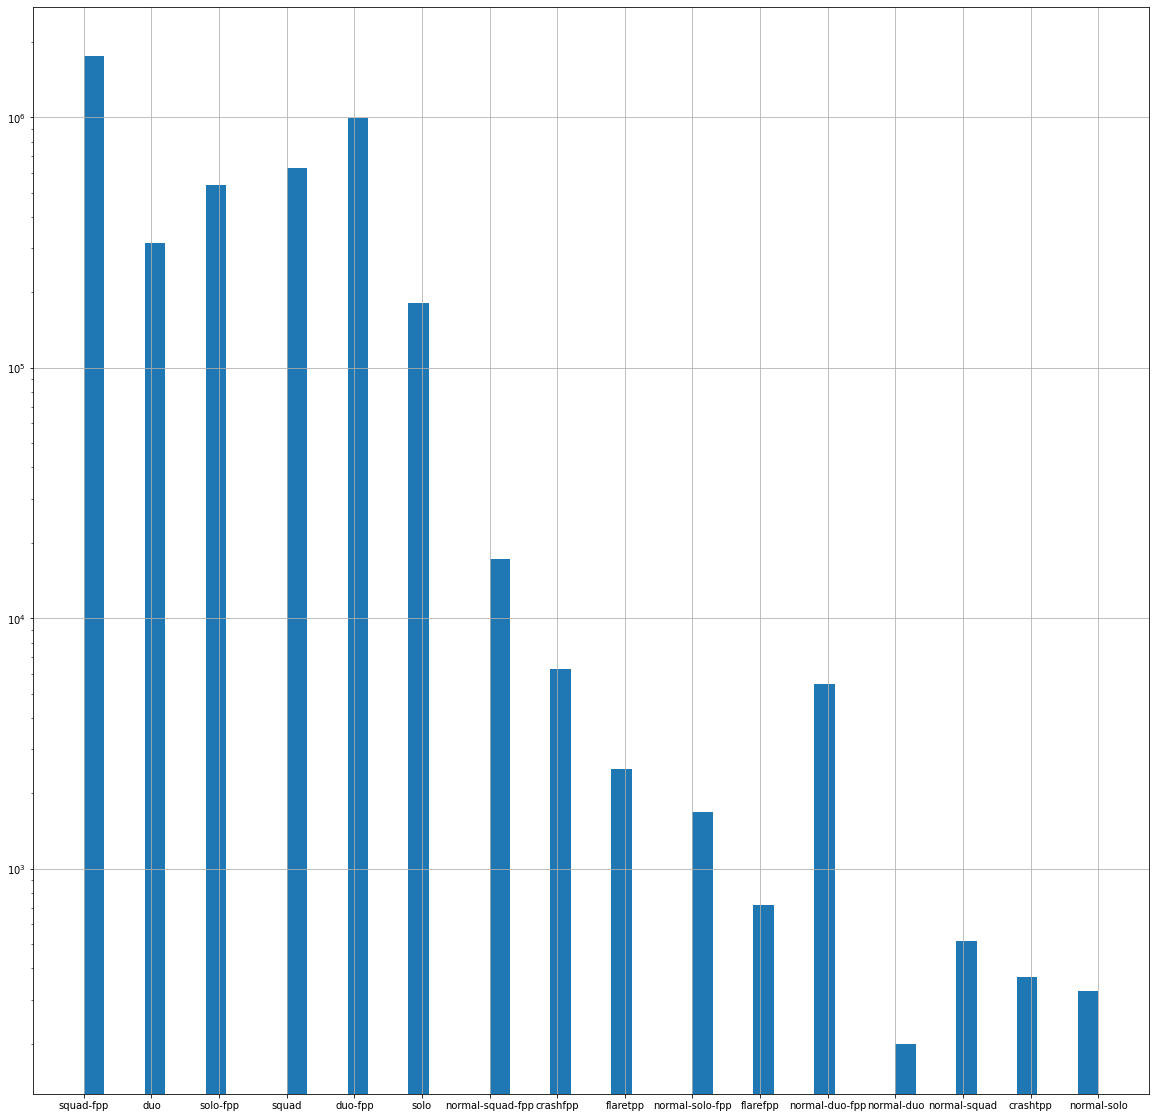

In [10]:
train['matchType'].astype('category').hist(bins=50,figsize=(20,20),log=True)

In [23]:
matchTypes

,counts,Percentage
matchType,,
crashfpp,6287,0.001414
crashtpp,371,0.000083
duo,313591,0.070518
duo-fpp,996691,0.224128
flarefpp,718,0.000161
flaretpp,2505,0.000563
normal-duo,199,0.000045
normal-duo-fpp,5489,0.001234
normal-solo,326,0.000073


### View the Average  WinPlacePerc for ranked and unranked

In [10]:
#Split ranked and unranked
search_values = ["normal","crash","flare"]
train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
train_normal = train[train.matchType.str.contains('|'.join(search_values))]

In [13]:
#Original dataset
Means = pd.DataFrame({'Mean': [train_rank["winPlacePerc"].mean(),train_normal["winPlacePerc"].mean()]})
Means

,Mean
0,0.472638
1,0.495746


### Plot Correlation Heat Map 
killPoints, matchDuration, maxPlace, numGroups, rankPoints, roadKills, teamKills, winPoints has no linear correlation to maxPlacePerc.

In [23]:
def plot_heat_map(X,y):
    dataset_ = pd.concat([X,y],axis=1)
    corr = dataset_.corr()
    plt.subplots(figsize=(30,20))
    sns.heatmap( corr, square=True, annot=True, fmt=".01f" )  
    plt.show()

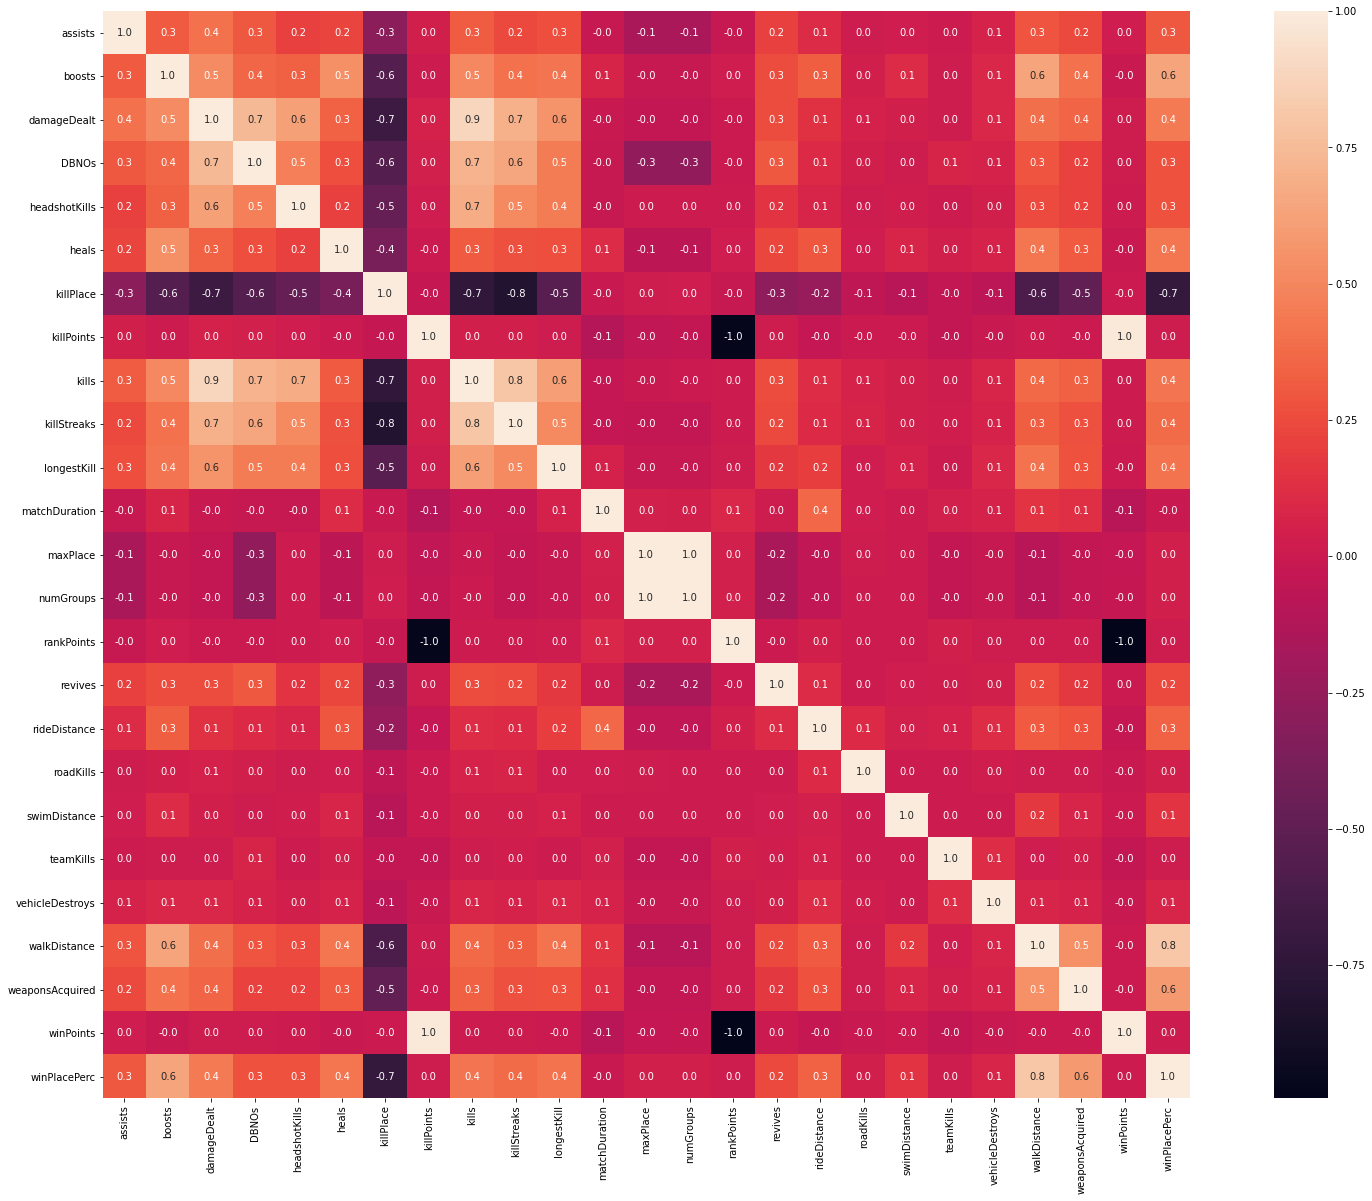

In [24]:
plot_heat_map(X_train,y_train)

### Split X and y value before preprocessing to make sure the consistency

In [7]:
#Randomly pick 80% samples as training set, 20% samples as test set
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2)

### Approach 1: 

1. Do One-Hot Encoding for "matchType"

In [112]:
def filter_1(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    return X_train_,X_test_

In [113]:
X_train_1,X_test_1 = filter_1(X_train,X_test)

#### XGBOOST 

In [117]:
xgboost_1 = XGBRegressor()

In [119]:
xgboost_1.fit(X_train_1,y_train)

[20:09:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [121]:
mean_absolute_error(xgboost_1.predict(X_test_1),y_test)

0.0690389156139343

#### SGD 

In [122]:
sgd_1 = SGDRegressor()

In [123]:
sgd_1.fit(X_train_1,y_train)

SGDRegressor()

In [124]:
mean_absolute_error(sgd_1.predict(X_test_1),y_test)

0.0927601356853177

### Approach 2: 

1.Delete inconsistent values such as rankPoints

2.Do One-Hot Encoding for "matchType"

In [125]:
def filter_2(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [126]:
X_train_2,X_test_2 = filter_2(X_train,X_test)

#### XGBOOST 

In [127]:
xgboost_2 = XGBRegressor()

In [128]:
xgboost_2.fit(X_train_2,y_train)

[20:17:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [129]:
mean_absolute_error(xgboost_2.predict(X_test_2),y_test)

0.06916933913012845

#### SGD 

In [130]:
sgd_2 = SGDRegressor()

In [131]:
sgd_2.fit(X_train_2,y_train)

SGDRegressor()

In [132]:
mean_absolute_error(sgd_2.predict(X_test_2),y_test)

0.09295102905504649

### Approach 3: 
1.Delete inconsistent values such as rankPoints

2.Combine ranked data with unranked data

3.Do One-Hot Encoding for "matchType"

In [9]:
def filter_3(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    X_ = X_.replace(["solo", "duo","squad","solo-fpp","duo-fpp", "squad-fpp"],
                    ["normal-solo","normal-duo", "normal-squad","normal-solo-fpp","normal-duo-fpp","normal-squad-fpp",])
    
    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [10]:
X_train_3,X_test_3 = filter_3(X_train,X_test)

#### XGBOOST 

In [11]:
xgboost_3 = XGBRegressor()

In [12]:
xgboost_3.fit(X_train_3,y_train)

[20:25:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [13]:
mean_absolute_error(xgboost_3.predict(X_test_3),y_test)

0.06914203148679031

#### SGD 

In [14]:
sgd_3 = SGDRegressor()

In [15]:
sgd_3.fit(X_train_3,y_train)

SGDRegressor()

In [16]:
mean_absolute_error(sgd_3.predict(X_test_3),y_test)

0.09305971238621764

### Approach 4:
1.Delete inconsistent values such as rankPoints

2.Split ranked data and unranked data (crash and flare are considered as unranked data)

3.Do One-Hot Encoding for "matchType"

In [23]:
def filter_4(X_train,X_test,y_train,y_test):
    
    train = pd.concat([X_train.copy(),y_train.copy()],axis=1)
    test = pd.concat([X_test.copy(),y_test.copy()],axis=1)
    
    #Split ranked and unranked
    search_values = ["normal","crash","flare"]
    train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
    train_normal = train[train.matchType.str.contains('|'.join(search_values))]
    test_rank = test[~test.matchType.str.contains('|'.join(search_values))]
    test_normal = test[test.matchType.str.contains('|'.join(search_values))]

    #Split X and y
    y_train_rank = train_rank["winPlacePerc"]
    X_train_rank = train_rank.drop(["winPlacePerc"],axis=1)
    
    y_train_normal = train_normal["winPlacePerc"]
    X_train_normal = train_normal.drop(["winPlacePerc"],axis=1)
    
    y_test_rank = test_rank["winPlacePerc"]
    X_test_rank = test_rank.drop(["winPlacePerc"],axis=1)
    
    y_test_normal = test_normal["winPlacePerc"]
    X_test_normal = test_normal.drop(["winPlacePerc"],axis=1)
    
    #Concatenate
    X_rank = pd.concat([X_train_rank,X_test_rank])
    X_normal = pd.concat([X_train_normal,X_test_normal])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_rank = X_rank.drop(["rankPoints","killPoints","winPoints"],axis=1)
    X_normal = X_normal.drop(["rankPoints","killPoints","winPoints"],axis=1)
    
    #Do One-Hot Encoding for "matchType"
    X_rank = pd.get_dummies(data = X_rank, columns = ["matchType"])
    X_normal = pd.get_dummies(data = X_normal, columns = ["matchType"])
    
    #Split into train and test again
    X_rank_train_ = X_rank.head(X_train_rank.shape[0])
    X_rank_test_ = X_rank.tail(X_test_rank.shape[0])
    
    X_normal_train_ = X_rank.head(X_train_normal.shape[0])
    X_normal_test_ = X_rank.tail(X_test_normal.shape[0])    
    
    return X_rank_train_,y_train_rank,X_rank_test_,y_test_rank,X_normal_train_,y_train_normal,X_normal_test_,y_test_normal

In [24]:
X_train_rank,y_train_rank,X_test_rank,y_test_rank,X_train_normal,y_train_normal,X_test_normal,y_test_normal = filter_4(X_train,X_test,y_train,y_test)

In [17]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

In [69]:
sgd_rank.fit(X_train_rank,y_train_rank)
sgd_normal.fit(X_train_normal,y_train_normal)

SGDRegressor()

In [70]:
(mean_absolute_error(sgd_rank.predict(X_test_rank),y_test_rank)*X_test_rank.shape[0]+mean_absolute_error(sgd_normal.predict(X_test_normal),y_test_normal)*X_test_normal.shape[0])/(X_test_rank.shape[0]+X_test_normal.shape[0])

0.09320165415469985

### Approach 5: 
1.Extract Solo and build a seperate model

2.Do One-Hot Encoding for other matchType

In [30]:
def filter_5(X_train,X_test,y_train,y_test):
    
    train = pd.concat([X_train.copy(),y_train.copy()],axis=1)
    test = pd.concat([X_test.copy(),y_test.copy()],axis=1)
    
    train_solo = train[train['matchType']=='solo']
    train_other = train[train['matchType']!='solo']
    test_solo = test[test['matchType']=='solo']
    test_other = test[test['matchType']!='solo']    
    
    y_train_solo = train_solo["winPlacePerc"]
    X_train_solo = train_solo.drop(["winPlacePerc"],axis=1)
    
    y_train_other = train_other["winPlacePerc"]
    X_train_other = train_other.drop(["winPlacePerc"],axis=1)
    
    y_test_solo = test_solo["winPlacePerc"]
    X_test_solo = test_solo.drop(["winPlacePerc"],axis=1)
    
    y_test_other = test_other["winPlacePerc"]
    X_test_other = test_other.drop(["winPlacePerc"],axis=1)
    
    X_train_solo = X_train_solo.drop(["matchType"],axis=1)
    X_test_solo = X_test_solo.drop(["matchType"],axis=1)
    
    other = pd.concat([X_train_other,X_test_other])
    other_one_hot = pd.get_dummies(data = other, columns = ["matchType"])
    
    X_train_other = other_one_hot.head(X_train_other.shape[0])
    X_test_other = other_one_hot.tail(X_test_other.shape[0])
    
    return X_train_solo,y_train_solo,X_test_solo,y_test_solo,X_train_other,y_train_other,X_test_other,y_test_other

In [31]:
X_train_solo,y_train_solo,X_test_solo,y_test_solo,X_train_other,y_train_other,X_test_other,y_test_other = filter_5(X_train,X_test,y_train,y_test)

#### XGBOOST 

In [26]:
xgboost_5_solo = XGBRegressor()
xgboost_5_other = XGBRegressor()

In [27]:
xgboost_5_solo.fit(X_train_solo,y_train_solo)

[20:47:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [28]:
xgboost_5_other.fit(X_train_other,y_train_other)

[20:47:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [32]:
(mean_absolute_error(xgboost_5_solo.predict(X_test_solo),y_test_solo)*X_test_solo.shape[0]+mean_absolute_error(xgboost_5_other.predict(X_test_other),y_test_other)*X_test_other.shape[0])/(X_test_solo.shape[0]+X_test_other.shape[0])

0.06810795293007697

#### Cross validation - not implemented yet

#### SGD 

In [ ]:
for i in range(len(sgds)):
    sgd = sgds[i]
    best_loss = None
    best_penalty = None
    best_max_iter = None
    best_learning_rate = None
    best_score = 0
    for loss in losses:
        sgd.loss = loss
        for penalty in penalties:
            sgd.penalty = penalty
            for max_iter in max_iters:
                sgd.max_iter = max_iter
                for learning_rate in learning_rates:
                    sgd.learning_rate = learning_rate
                    scores = cross_val_score(sgd, X_train_list[i], y_train, cv=5,scoring = "neg_mean_absolute_error")
                    avg_score = sum(-scores)/5
                    if(avg_score>best_score):
                        best_score = avg_score
                        best_loss = loss
                        best_penalty = penalty
                        best_max_iter = max_iter
                        best_learning_rate = learning_rate
                    print("model: ",sgd, "score: ",avg_score)
    sgds[i].loss = best_loss
    sgds[i].penalty = best_penalty
    sgds[i].max_iter = best_max_iter
    sgds[i].learning_rate = best_learning_rate